# Tesseract

In [ ]:
!sudo apt install -q tesseract-ocr

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,862 kB/s)
debconf: 

In [ ]:
!pip install pytesseract

     |████████████████████████████████| 4.3 MB 9.5 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install Pillow==9.0.0

     |████████████████████████████████| 4.3 MB 7.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.1.0
    Uninstalling Pillow-9.1.0:
      Successfully uninstalled Pillow-9.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  tesseract-ocr-ind
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 536 kB of archives.
After this operation, 1,138 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-ind all 4.00~git24-0e00fe6-1.2 [536 kB]
Fetched 536 kB in 1s (521 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tt

In [ ]:
# import libraries
import csv
import cv2
import pytesseract
import os

import numpy as np
import argparse
import imutils
from skimage.filters import threshold_local


from google.colab.patches import cv2_imshow

### Four Point Transform


In [ ]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

#### Edge Detection

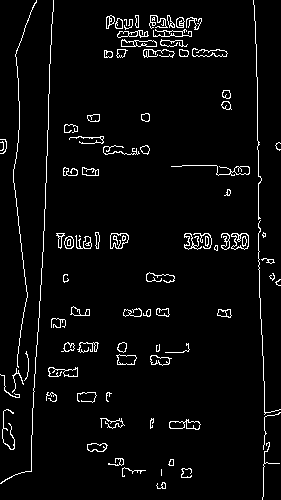

In [ ]:
#def edge_detection(image):
# to the new height, clone it, and resize it
image = cv2.imread("bon-makan-di-paul.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
# show the original image and the edge detected image
cv2_imshow(edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Contours

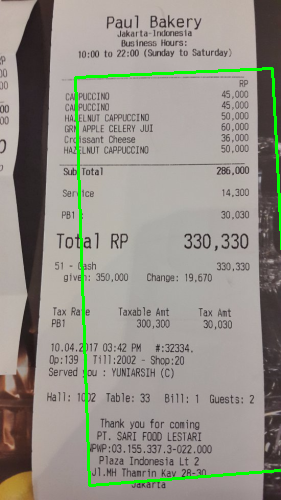

In [ ]:
#def contours(image, edged):
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
conts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
conts = sorted(conts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in conts:
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  # if our approximated contour has four points, then we
  # can assume that we have found our screen
  if len(approx) == 4:
    screenCnt = approx
    break
# show the contour (outline) of the piece of paper
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Apply Four Point Transform

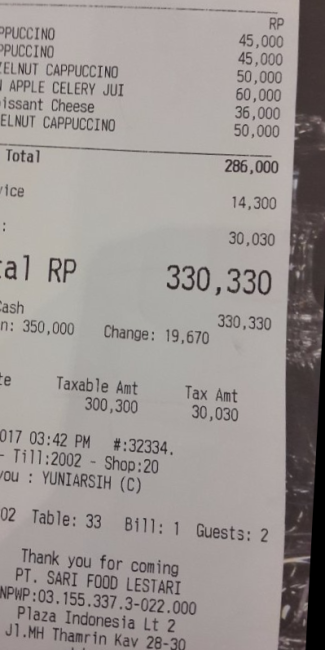

-1

In [ ]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect

# show the original and scanned images
cv2_imshow(imutils.resize(warped, height = 650))
cv2.waitKey(0)

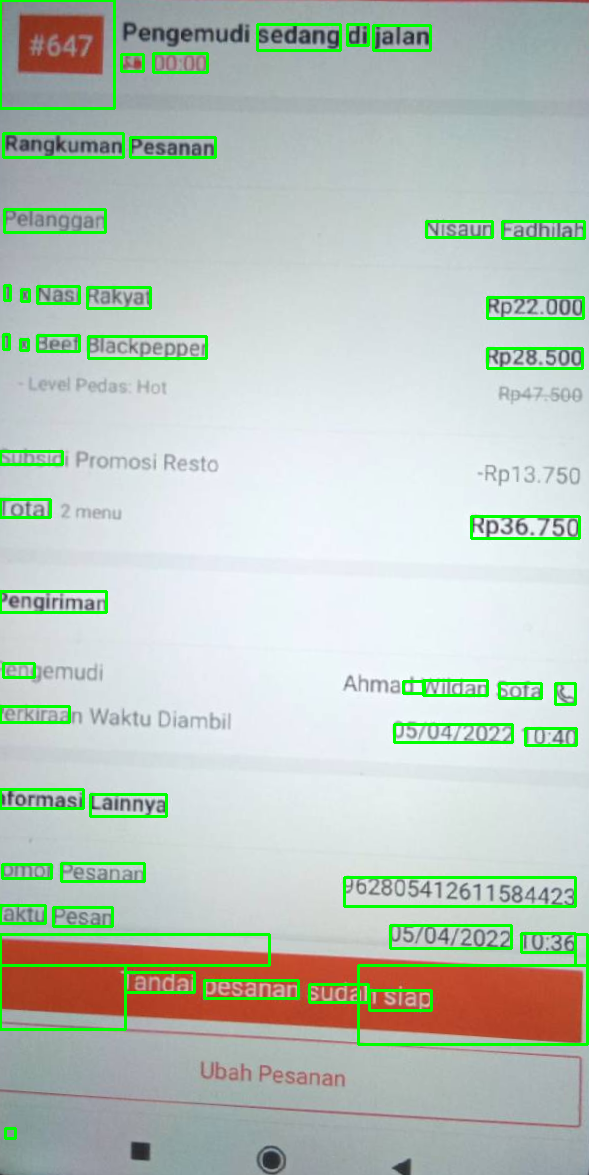

In [ ]:
# calling parse_text function to get text from image_org by Tesseract.
parsed_data_org = parse_text_org(warped)
# defining threshold for draw box
accuracy_threshold = 30
# calling draw_boxes function which will draw dox around text area.
draw_boxes_org(warped, parsed_data_org, accuracy_threshold)
# calling format_text function which will format text according to input image_org
arranged_text_org = format_text_org(parsed_data_org)
# calling write_text function which will write arranged text into file
write_text_org(arranged_text_org)

In [ ]:
if __name__ == "__main__":
# apply the four point transform to obtain a top-down
# view of the original image
    image = cv2.imread('20220426-101516.png')
    ratio = image.shape[0] / 500.0
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

### Experiment with thresholding

In [ ]:
def pre_processing(image):
    """
    This function take one argument as
    input. this function will convert
    input image to binary image
    :param image: image
    :return: thresholded image
    """
    # Convert to gray image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # converting it to binary image
    #threshold_img = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Adaptive thresholding
    threshold_img = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    # saving image to view threshold image
    #path = '/content/Result'
    #cv2.imwrite(os.path.join (path, 'thresholded.png'), threshold_img)
    cv2.imwrite('thresholded.png', threshold_img)

    cv2_imshow(threshold_img)
    # # Maintain output window until
    # # user presses a key
    # cv2.waitKey(0)
    # # Destroying present windows on screen
    # cv2.destroyAllWindows()

    return threshold_img


def parse_text(threshold_img):
    """
    This function take one argument as
    input. this function will feed input
    image to tesseract to predict text.
    :param threshold_img: image
    return: meta-data dictionary
    """
    # configuring parameters for tesseract
    tesseract_config = r'--oem 3 --psm 4'
    # now feeding image to tesseract
    details = pytesseract.image_to_data(threshold_img, output_type=pytesseract.Output.DICT,
                                        config=tesseract_config, lang='eng+ind')
    return details


def draw_boxes(image, details, threshold_point):
    """
    This function takes three argument as
    input. it draw boxes on text area detected
    by Tesseract. it also writes resulted image to
    your local disk so that you can view it.
    :param image: image
    :param details: dictionary
    :param threshold_point: integer
    :return: None
    """
    total_boxes = len(details['text'])
    for sequence_number in range(total_boxes):
        if int(details['conf'][sequence_number]) > threshold_point:
            (x, y, w, h) = (details['left'][sequence_number], details['top'][sequence_number],
                            details['width'][sequence_number], details['height'][sequence_number])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # saving image to local
    #path = '/content/Result'
    #cv2.imwrite(os.path.join (path, 'captured_text_area.png'), image)
    cv2.imwrite('captured_text_area.png', image)

    # display image
    cv2_imshow(image)
    # # Maintain output window until user presses a key
    # cv2.waitKey(0)
    # # Destroying present windows on screen
    # cv2.destroyAllWindows()


def format_text(details):
    """
    This function take one argument as
    input.This function will arrange
    resulted text into proper format.
    :param details: dictionary
    :return: list
    """
    parse_text = []
    word_list = []
    last_word = ''
    for word in details['text']:
        if word != '':
            word_list.append(word)
            last_word = word
        if (last_word != '' and word == '') or (word == details['text'][-1]):
            parse_text.append(word_list)
            word_list = []

    return parse_text


def write_text(formatted_text):
    """
    This function take one argument.
    it will write arranged text into
    a file.
    :param formatted_text: list
    :return: None
    """
    with open('resulted_text.txt', 'w', newline="") as file:
        csv.writer(file, delimiter=" ").writerows(formatted_text)

#### Run the code

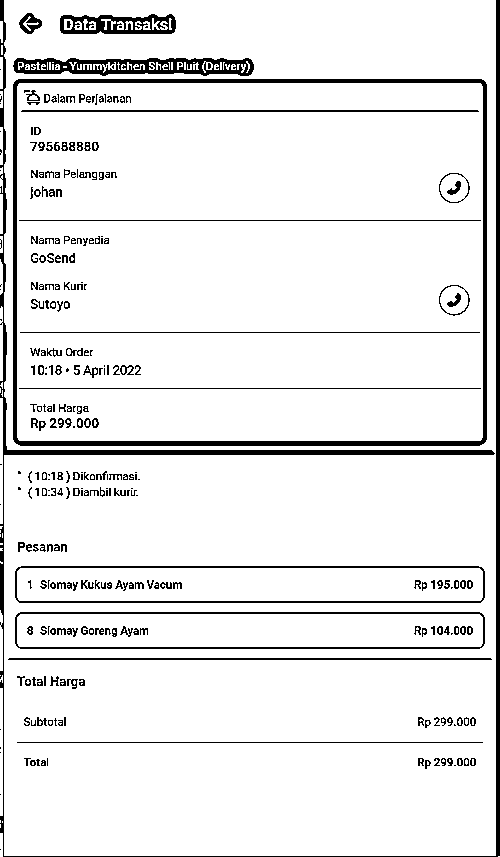

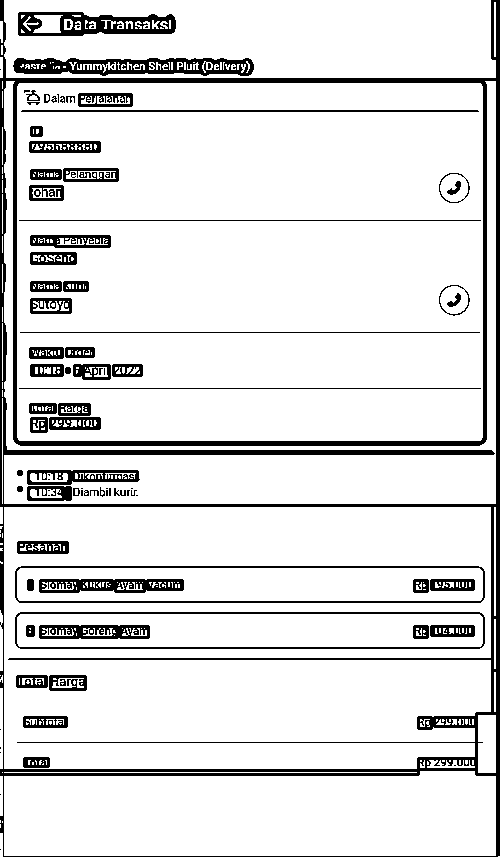

In [ ]:
if __name__ == "__main__":
    # reading image from local
    image = cv2.imread('20220426-101516.png')
    # calling pre_processing function to perform pre-processing on input image.
    thresholds_image = pre_processing(image)
    # calling parse_text function to get text from image by Tesseract.
    parsed_data = parse_text(thresholds_image)
    # defining threshold for draw box
    accuracy_threshold = 30
    # calling draw_boxes function which will draw dox around text area.
    draw_boxes(thresholds_image, parsed_data, accuracy_threshold)
    # calling format_text function which will format text according to input image
    arranged_text = format_text(parsed_data)
    # calling write_text function which will write arranged text into file
    write_text(arranged_text)

### Experiment with no preprocessing

In [ ]:
def parse_text_org(image_org):
    """
    This function take one argument as
    input. this function will feed input
    image_org to tesseract to predict text.
    :param threshold_img: image_org
    return: meta-data dictionary
    """
    # configuring parameters for tesseract
    tesseract_config = r'--oem 3 --psm 4'
    # now feeding image_org to tesseract
    details_org = pytesseract.image_to_data(image_org, output_type=pytesseract.Output.DICT,
                                        config=tesseract_config, lang='eng+ind')
    return details_org


def draw_boxes_org(image_org, details_org, threshold_point):
    """
    This function takes three argument as
    input. it draw boxes on text area detected
    by Tesseract. it also writes resulted image_org to
    your local disk so that you can view it.
    :param image_org: image_org
    :param details_org: dictionary
    :param threshold_point: integer
    :return: None
    """
    total_boxes_org = len(details_org['text'])
    for sequence_number_org in range(total_boxes_org):
        if int(details_org['conf'][sequence_number_org]) > threshold_point:
            (x, y, w, h) = (details_org['left'][sequence_number_org], details_org['top'][sequence_number_org],
                            details_org['width'][sequence_number_org], details_org['height'][sequence_number_org])
            image_org = cv2.rectangle(image_org, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # saving image_org to local
    #path = '/content/Result'
    #cv2.imwrite(os.path.join (path,'captured_text_area_org.png', image_org))

    cv2.imwrite('captured_text_area_org.png', image_org)
    # # display image_org
    cv2_imshow(image_org)
    # # Maintain output window until user presses a key
    # cv2.waitKey(0)
    # # Destroying present windows on screen
    # cv2.destroyAllWindows()


def format_text_org(details_org):
    """
    This function take one argument as
    input.This function will arrange
    resulted text into proper format.
    :param details_org: dictionary
    :return: list
    """
    parse_text_org = []
    word_list_org = []
    last_word_org = ''
    for word_org in details_org['text']:
        if word_org != '':
            word_list_org.append(word_org)
            last_word_org = word_org
        if (last_word_org != '' and word_org == '') or (word_org == details_org['text'][-1]):
            parse_text_org.append(word_list_org)
            word_list_org = []

    return parse_text_org


def write_text_org(formatted_text_org):
    """
    This function take one argument.
    it will write arranged text into
    a file.
    :param formatted_text_org: list
    :return: None
    """
    with open('resulted_text_org.txt', 'w', newline="") as file:
        csv.writer(file, delimiter=" ").writerows(formatted_text_org)

#### Run experiment

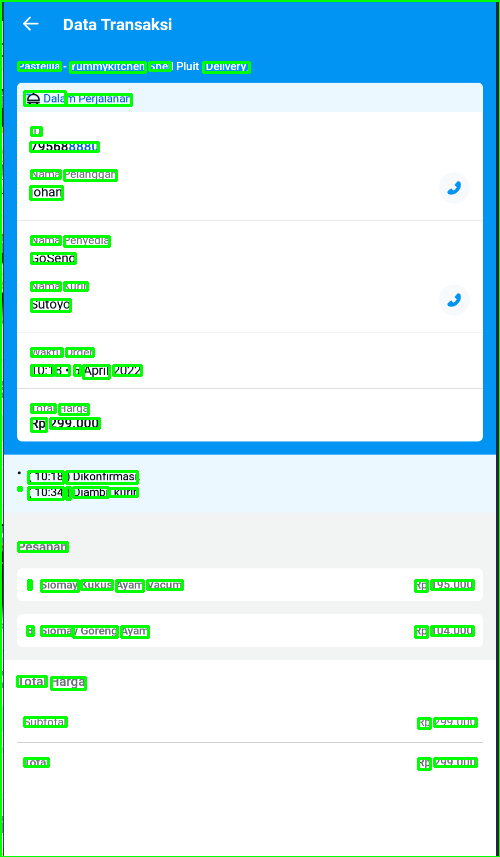

In [ ]:
if __name__ == "__main__":
    # reading image_org from local
    image_org = cv2.imread('20220426-101516.png')
    # calling parse_text function to get text from image_org by Tesseract.
    parsed_data_org = parse_text_org(image_org)
    # defining threshold for draw box
    accuracy_threshold = 30
    # calling draw_boxes function which will draw dox around text area.
    draw_boxes_org(image_org, parsed_data_org, accuracy_threshold)
    # calling format_text function which will format text according to input image_org
    arranged_text_org = format_text_org(parsed_data_org)
    # calling write_text function which will write arranged text into file
    write_text_org(arranged_text_org)

In [ ]:
custom_config = r'--oem 3 --psm 4'
img1_text = pytesseract.image_to_string("20220426-101516.png", config = custom_config)
print(img1_text)

Ree ORCC

eee eS r)

Balam Peralanan

1D
795688880

Nama Pelanggan
Johan

Nama Penyedia
Gosend

Nama Kurir
Sutoyo

Waktu Order
10:18 + 5 April 2022

Total Harga
Rp 299.000

+ (10:18) Dikonfirmasi
* (10:34) Diambit kuric

Pesanan

1 Siomay Kukus Ayam Vacum Rp 195.000

8 Slomay Goreng Ayam Rp 104,000

Total Harga

Subtotal Rp 299.000

Total Rp 299.000

 



# EasyOCR

In [ ]:
pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.5.0
bs4                           0.

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 26 kB/s 
     |████████████████████████████████| 47.6 MB 124 kB/s 


In [ ]:
# import libraries
import csv
import cv2
import easyocr
import os
import PIL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils

import re
import time
import datetime
import json
import requests


from PIL import ImageDraw

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.cloud import bigquery

from google.colab import auth
from google.colab.patches import cv2_imshow

## Functions

### Unzip Images

In [ ]:
!unzip "/content/Invoices.zip"

### Reader

In [ ]:
# Reader function (english and indonesian)
reader = easyocr.Reader(['en', 'id'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

### Bounding Box

In [ ]:
# Draw bounding boxes
def draw_boxes(image, bounds, color='red', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

## Traveloka

### Input Images

In [ ]:
trav_1 = "/content/Traveloka/20220519-090147.jpg"
trav_2 = "/content/Traveloka/20220519-090138.jpg"
trav_3 = "/content/Traveloka/20220520_101504.jpg"

In [ ]:
trav1 = PIL.Image.open("/content/Traveloka/20220519-090147.jpg")
trav2 = PIL.Image.open("/content/Traveloka/20220519-090138.jpg")
trav3 = PIL.Image.open("/content/Traveloka/20220520_101504.jpg")

### OCR

In [ ]:
trav_text_1 = reader.readtext(trav_1, paragraph = True, detail = 0, decoder = "beamsearch", width_ths = 15)
trav_text_1

['17:10',
 'Ant',
 '41 = 0',
 'Data Transaksi',
 'Selesai',
 'ID 802348034',
 'Nama Pelanggan Meirisa $',
 'Nama Penyedia Traveloka Courier',
 'Nama Kurir Seno Rizky Hariyadi',
 'Waktu Order 14:14 . 21 April 2022',
 'Total Harga Rp 38.500',
 '14:16 ) Dikonfirmasi. 14.36 ) Diambil kurir. 14.45 ) Selesai',
 'Pesanan',
 '1  1/2 Lusin Classic  Rp 38.500',
 'Donat Gula',
 'Donat Gula',
 'nana+Cula']

In [ ]:
trav_text_2 = reader.readtext(trav_2, paragraph = True, detail = 0, decoder = "beamsearch", width_ths = 15)
trav_text_2

['08.55 j M @ "4" 289 =ul @3',
 'Data Transaksi',
 'Dailybox - Yummykitchen Shell Jatimekar (Delivery)',
 'Selesai',
 'ID',
 '804571097',
 'Nama Pelanggan edward',
 'Nama Penyedia Traveloka Courier',
 'Nama Kurir Rahmat Setiaji',
 'Waktu Order',
 '17:26 . 26 April 2022',
 'Total Harga Rp 39. 500',
 '( 17:26 ) Dikonfirmasi: 17:33 ) Diambil kurir . 17:49 ) Selesai',
 'Pesanan',
 'Butter Soy Sauce Chicken  Rp 39. 500 Soy',
 'Perlu Alat Makan',
 'Total Harga',
 'Subtotal',
 'Rp 39. 500']

In [ ]:
trav_text_3 = reader.readtext(trav_3, paragraph = True, detail = 1, decoder = "beamsearch", min_size = 50, width_ths = 15)
trav_text_3

[[[[189, 399], [336, 399], [336, 455], [189, 455]], '17.10'],
 [[[389, 543], [968, 543], [968, 635], [389, 635]], 'Data Transaksi'],
 [[[285, 794], [495, 794], [495, 862], [285, 862]], 'ISelesail'],
 [[[222, 973], [583, 973], [583, 1118], [222, 1118]], 'IID 802348034'],
 [[[227, 1181], [696, 1181], [696, 1354], [227, 1354]],
  'Nama Pelanggan Meirisa $'],
 [[[235, 1530], [767, 1530], [767, 1695], [235, 1695]],
  'Nama Penyedia Traveloka Courier'],
 [[[238, 1768], [829, 1768], [829, 1937], [238, 1937]],
  'Nama Kurir Seno Rizky Hariyadil'],
 [[[242, 2095], [867, 2095], [867, 2263], [242, 2263]],
  'Waktorden 14.14 . 21 April 2022'],
 [[[242, 2375], [559, 2375], [559, 2531], [242, 2531]],
  'Total Hargal Rp 38.500'],
 [[[232, 2712], [809, 2712], [809, 2943], [232, 2943]],
  '((14.16 ) Dikonfirmasi ( 14.36 ) Diambil kurir. ( 14.45 ) Selesai'],
 [[[181, 3139], [452, 3139], [452, 3220], [181, 3220]], 'Pesanan'],
 [[[296, 3323], [1613, 3323], [1613, 3401], [296, 3401]], 'aoo'],
 [[[292, 3447

### Bounding Box

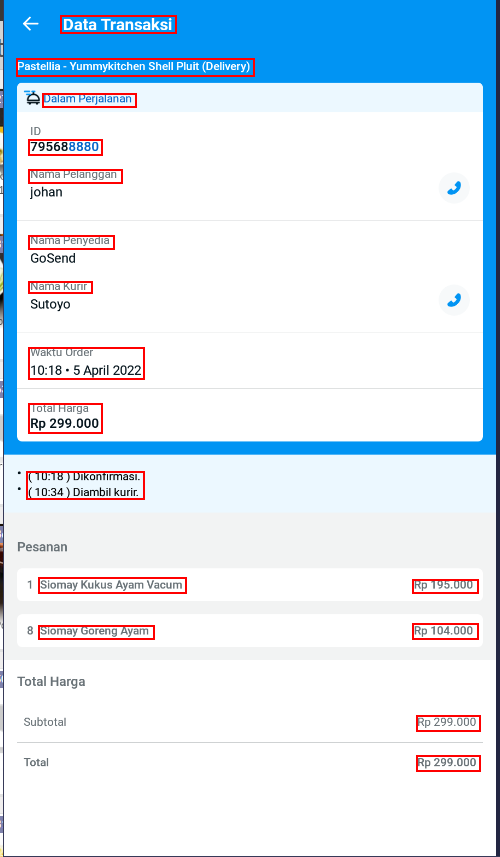

In [ ]:
draw_boxes(trav1, trav_text_1)

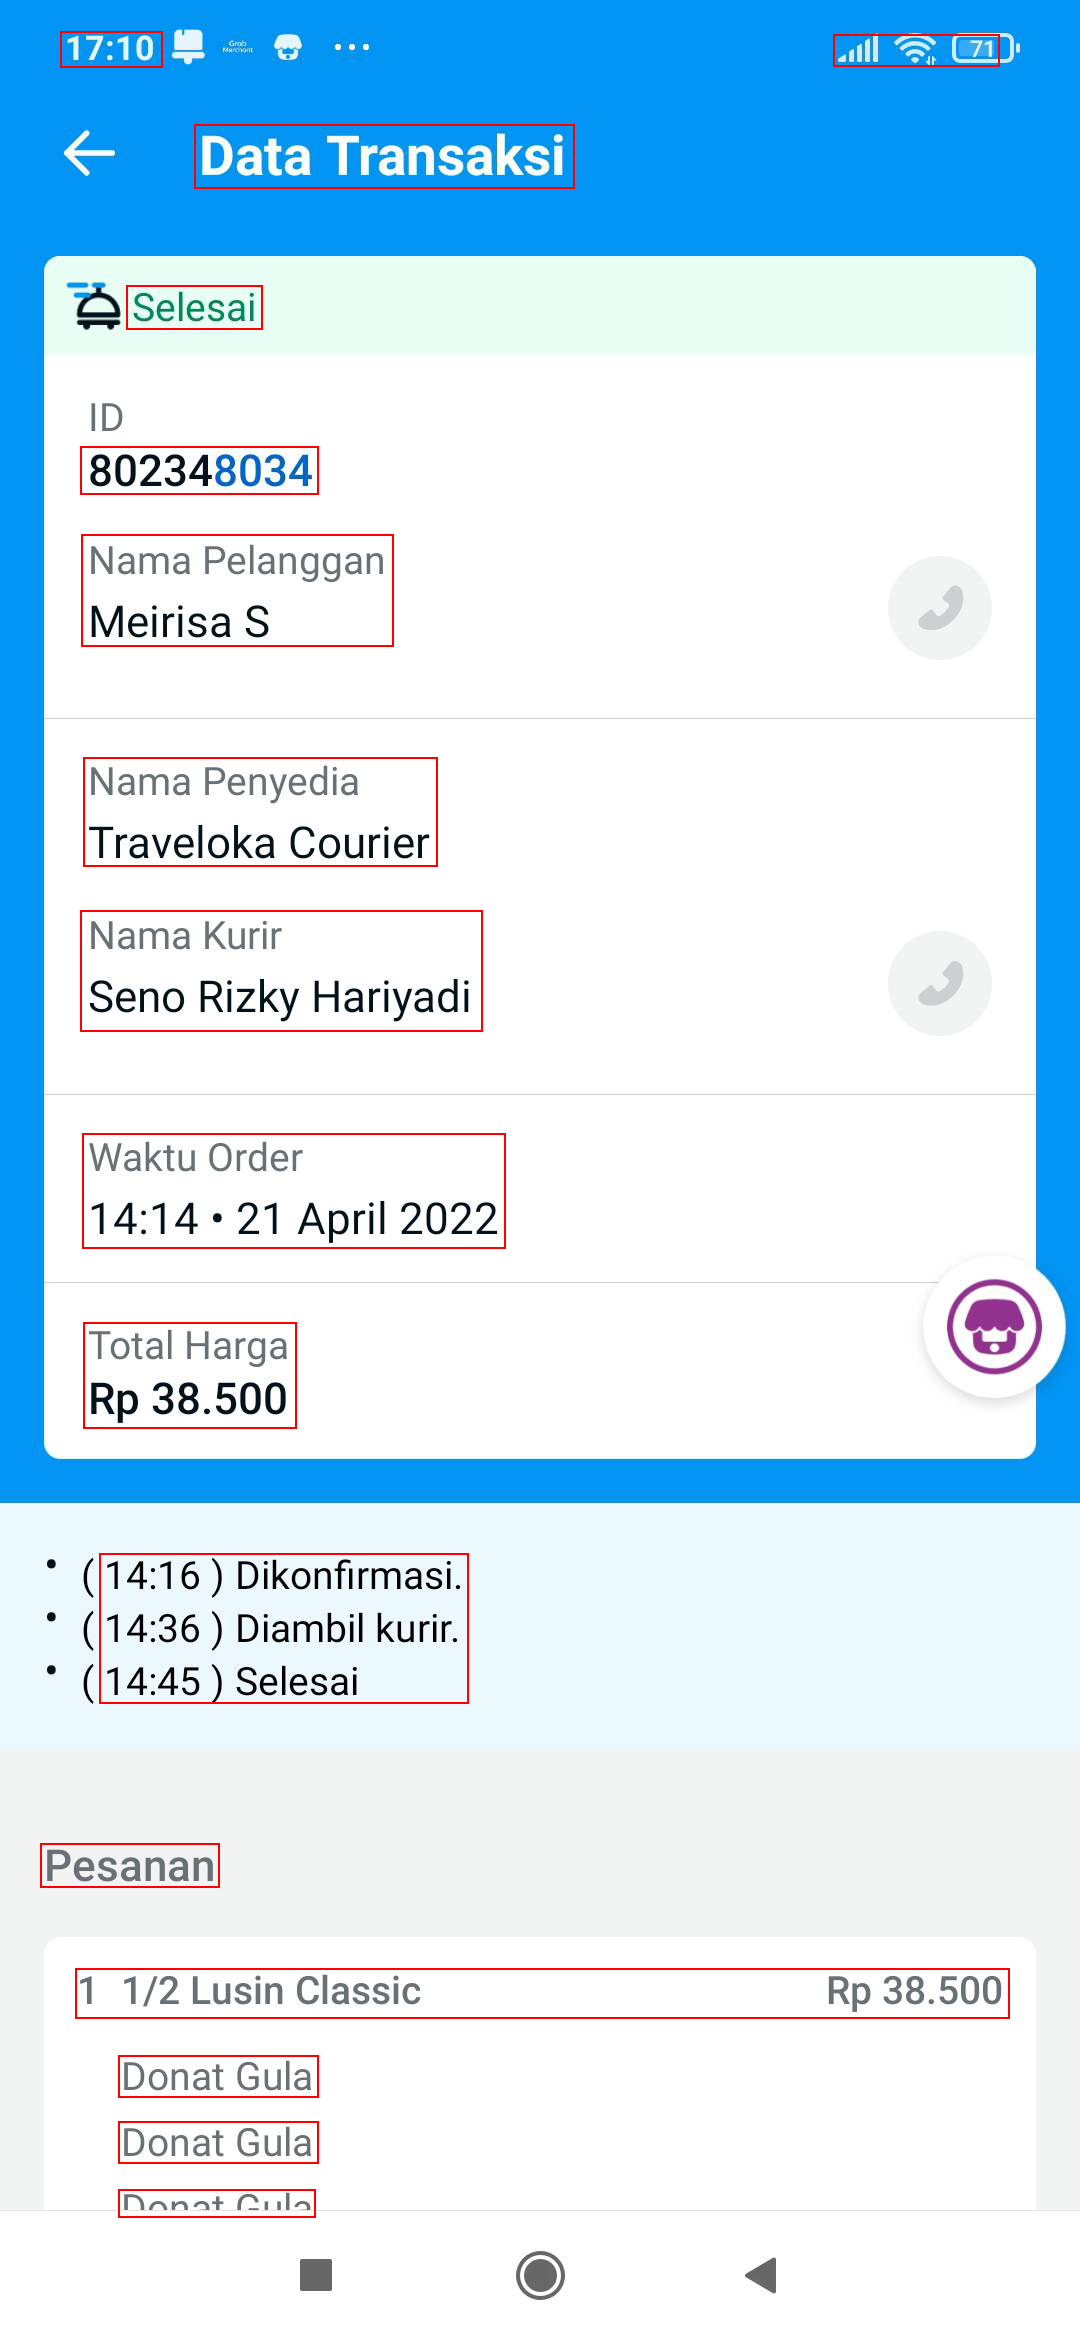

In [ ]:
draw_boxes(trav2, trav_text_2)

In [ ]:
draw_boxes(trav3, trav_text_3)

### Output

In [ ]:
for line in trav_text_3:
  if "Nama Pelanggan" in line:
    trav_cus_name = line
    trav_cus_name = trav_cus_name.replace("Nama Pelanggan", "")
    trav_cus_name = trav_cus_name.strip()

trav_cus_name

'edward'

In [ ]:
for line in trav_text_3:
  if "Nama Kurir" in line:
    trav_driver_name = line
    trav_driver_name = trav_driver_name.replace("Nama Kurir", "")
    trav_driver_name = trav_driver_name.strip()

trav_driver_name

'Rahmat Setiaji'

In [ ]:
trav_extracted = []
trav_extracted.extend((trav_cus_name, trav_driver_name))
trav_extracted

['edward', 'Rahmat Setiaji']

## Shopee

### Input Images

In [ ]:
shp_1 = "/content/Shopee_Food/20220519-091344.jpg"
shp_2 = "/content/Shopee_Food/20220519-090050.jpg"
shp_3 = "/content/Shopee_Food/20220520_101448.jpg"

In [ ]:
shp1 = PIL.Image.open("/content/Shopee_Food/20220519-091344.jpg")
shp2 = PIL.Image.open("/content/Shopee_Food/20220519-090050.jpg")
shp3 = PIL.Image.open("/content/Shopee_Food/20220520_101448.jpg")

### OCR

In [ ]:
shp_text_1 = reader.readtext(shp_1, paragraph = True, decoder = "beamsearch", min_size = 60)
shp_text_1

[[[[61, 31], [161, 31], [161, 67], [61, 67]], '16:50'],
 [[[954, 36], [1016, 36], [1016, 62], [954, 62]], '02'],
 [[[148, 126], [565, 126], [565, 187], [148, 187]], 'Rincian Pesanan'],
 [[[65, 318], [510, 318], [510, 374], [65, 374]], '#290 Telah Diantar'],
 [[[28, 498], [410, 498], [410, 550], [28, 550]], 'Rangkuman Pesanan'],
 [[[25, 628], [224, 628], [224, 688], [25, 688]], 'Pelanggan'],
 [[[832, 632], [1052, 632], [1052, 684], [832, 684]], 'Brigitha Dea'],
 [[[60, 766], [306, 766], [306, 816], [60, 816]], 'x Nasi Rakyat'],
 [[[874, 761], [1052, 761], [1052, 817], [874, 817]], 'Rp22.000'],
 [[[29, 905], [259, 905], [259, 950], [29, 950]], 'Total 1 menu'],
 [[[853, 901], [1052, 901], [1052, 958], [853, 958]], 'Rp22.000'],
 [[[28, 1067], [239, 1067], [239, 1119], [28, 1119]], 'Pengiriman'],
 [[[28, 1190], [384, 1190], [384, 1394], [28, 1394]],
  'Pengemudi Waktu Pengambilan Waktu Pengiriman'],
 [[[740, 1187], [992, 1187], [992, 1235], [740, 1235]], 'Amir Mahmud'],
 [[[731, 1267], [105

In [ ]:
shp_text_2 = reader.readtext(shp_2, paragraph = True, detail = 0, decoder = "beamsearch", min_size = 60, width_ths = 15)
shp_text_2

['15:29',
 'Rincian Pesanan',
 '#300   Telah Diantar',
 'Rangkuman Pesanan',
 'Pelanggan  shopatharuu',
 'Test livia',
 '1 x Nasi Rakyat Telur: Sunny Side Up',
 'Rp27.500',
 'Total 1 menu',
 'Rp27.500',
 'Pengiriman',
 'Pengemudi   Syarif Mahmudy Waktu Pengambilan  17/05/2022 17.34 Waktu Pengiriman  17/05/2022 17.39',
 'Informasi Lainnya',
 'Nomor Pesanan  1022662045041664413',
 'Waktu Pesan 17/05/2022 17.25']

In [ ]:
shp_text_3 = reader.readtext(shp_3, paragraph = True, decoder = "beamsearch", min_size = 50, width_ths = 15)
shp_text_3

[[[[156, 243], [321, 243], [321, 311], [156, 311]], 's'],
 [[[304, 414], [988, 414], [988, 514], [304, 514]], 'Rincian Pesanan'],
 [[[167, 737], [893, 737], [893, 829], [167, 829]], '#300  Telah Diantar'],
 [[[105, 1037], [727, 1037], [727, 1122], [105, 1122]], 'Rangkuman Pesanan'],
 [[[101, 1253], [1783, 1253], [1783, 1362], [101, 1362]],
  'Pelanggan  shopatharuu'],
 [[[175, 1538], [397, 1538], [397, 1602], [175, 1602]], 'Test livia'],
 [[[117, 1715], [1763, 1715], [1763, 1918], [117, 1918]],
  '1 x Nasi Rakyat   Rp27.500 Telur: Sunny Side Up'],
 [[[116, 2054], [483, 2054], [483, 2131], [116, 2131]], 'Total 1 menu'],
 [[[1424, 2079], [1748, 2079], [1748, 2164], [1424, 2164]], 'Rp27.500'],
 [[[119, 2316], [451, 2316], [451, 2392], [119, 2392]], 'Pengiriman'],
 [[[115, 2501], [1732, 2501], [1732, 2850], [115, 2850]],
  'Pengemudi > Syarif Mahmudy & Waktu Pengambilan   17/05/2022 17.34 Waktu Pengiriman  17/05/2022 17.39'],
 [[[116, 2964], [624, 2964], [624, 3060], [116, 3060]], 'Informa

### Bounding Box

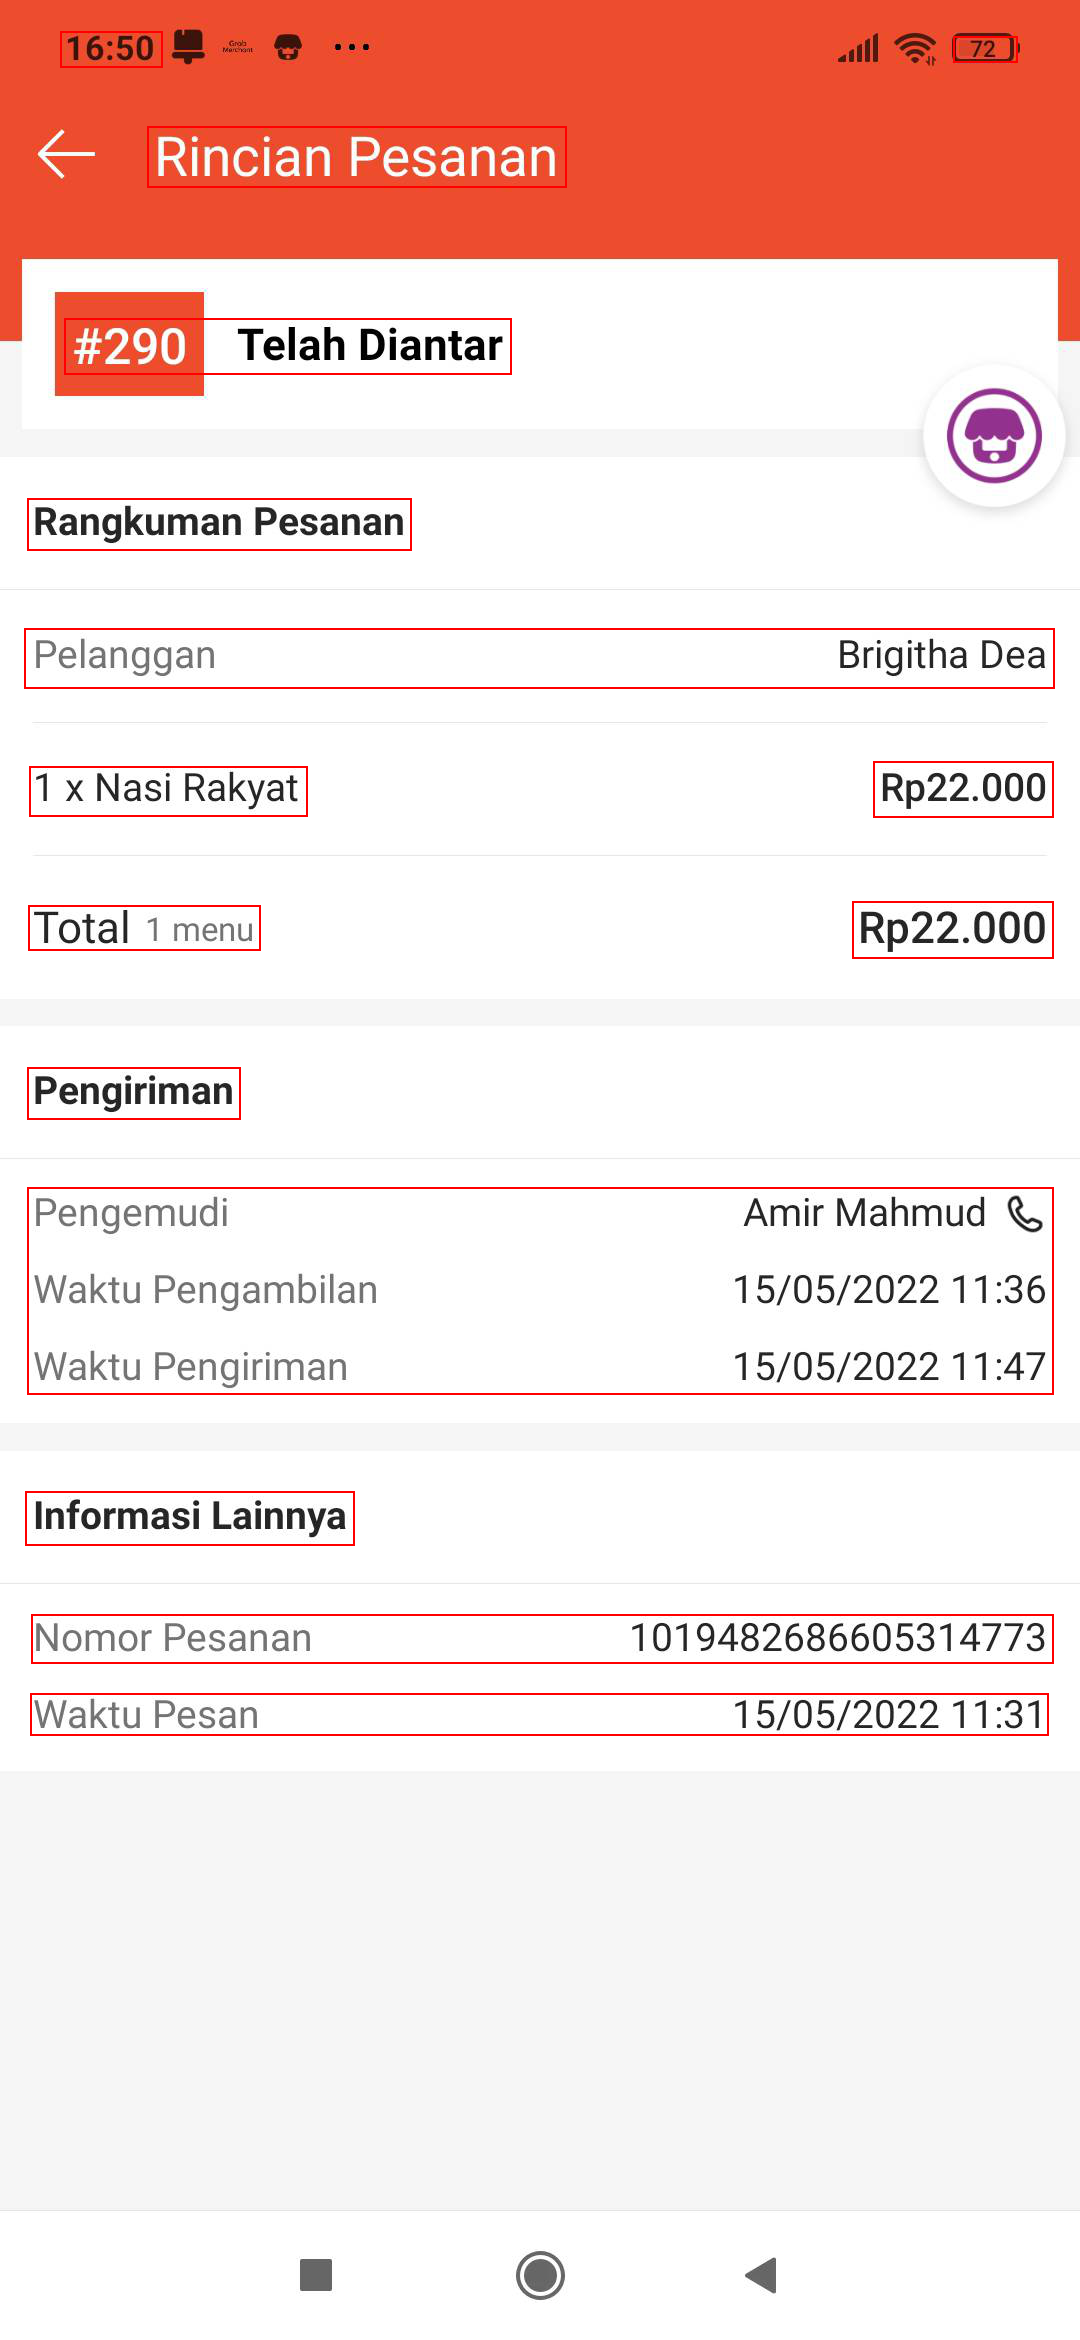

In [ ]:
draw_boxes(shp1, shp_text_1)

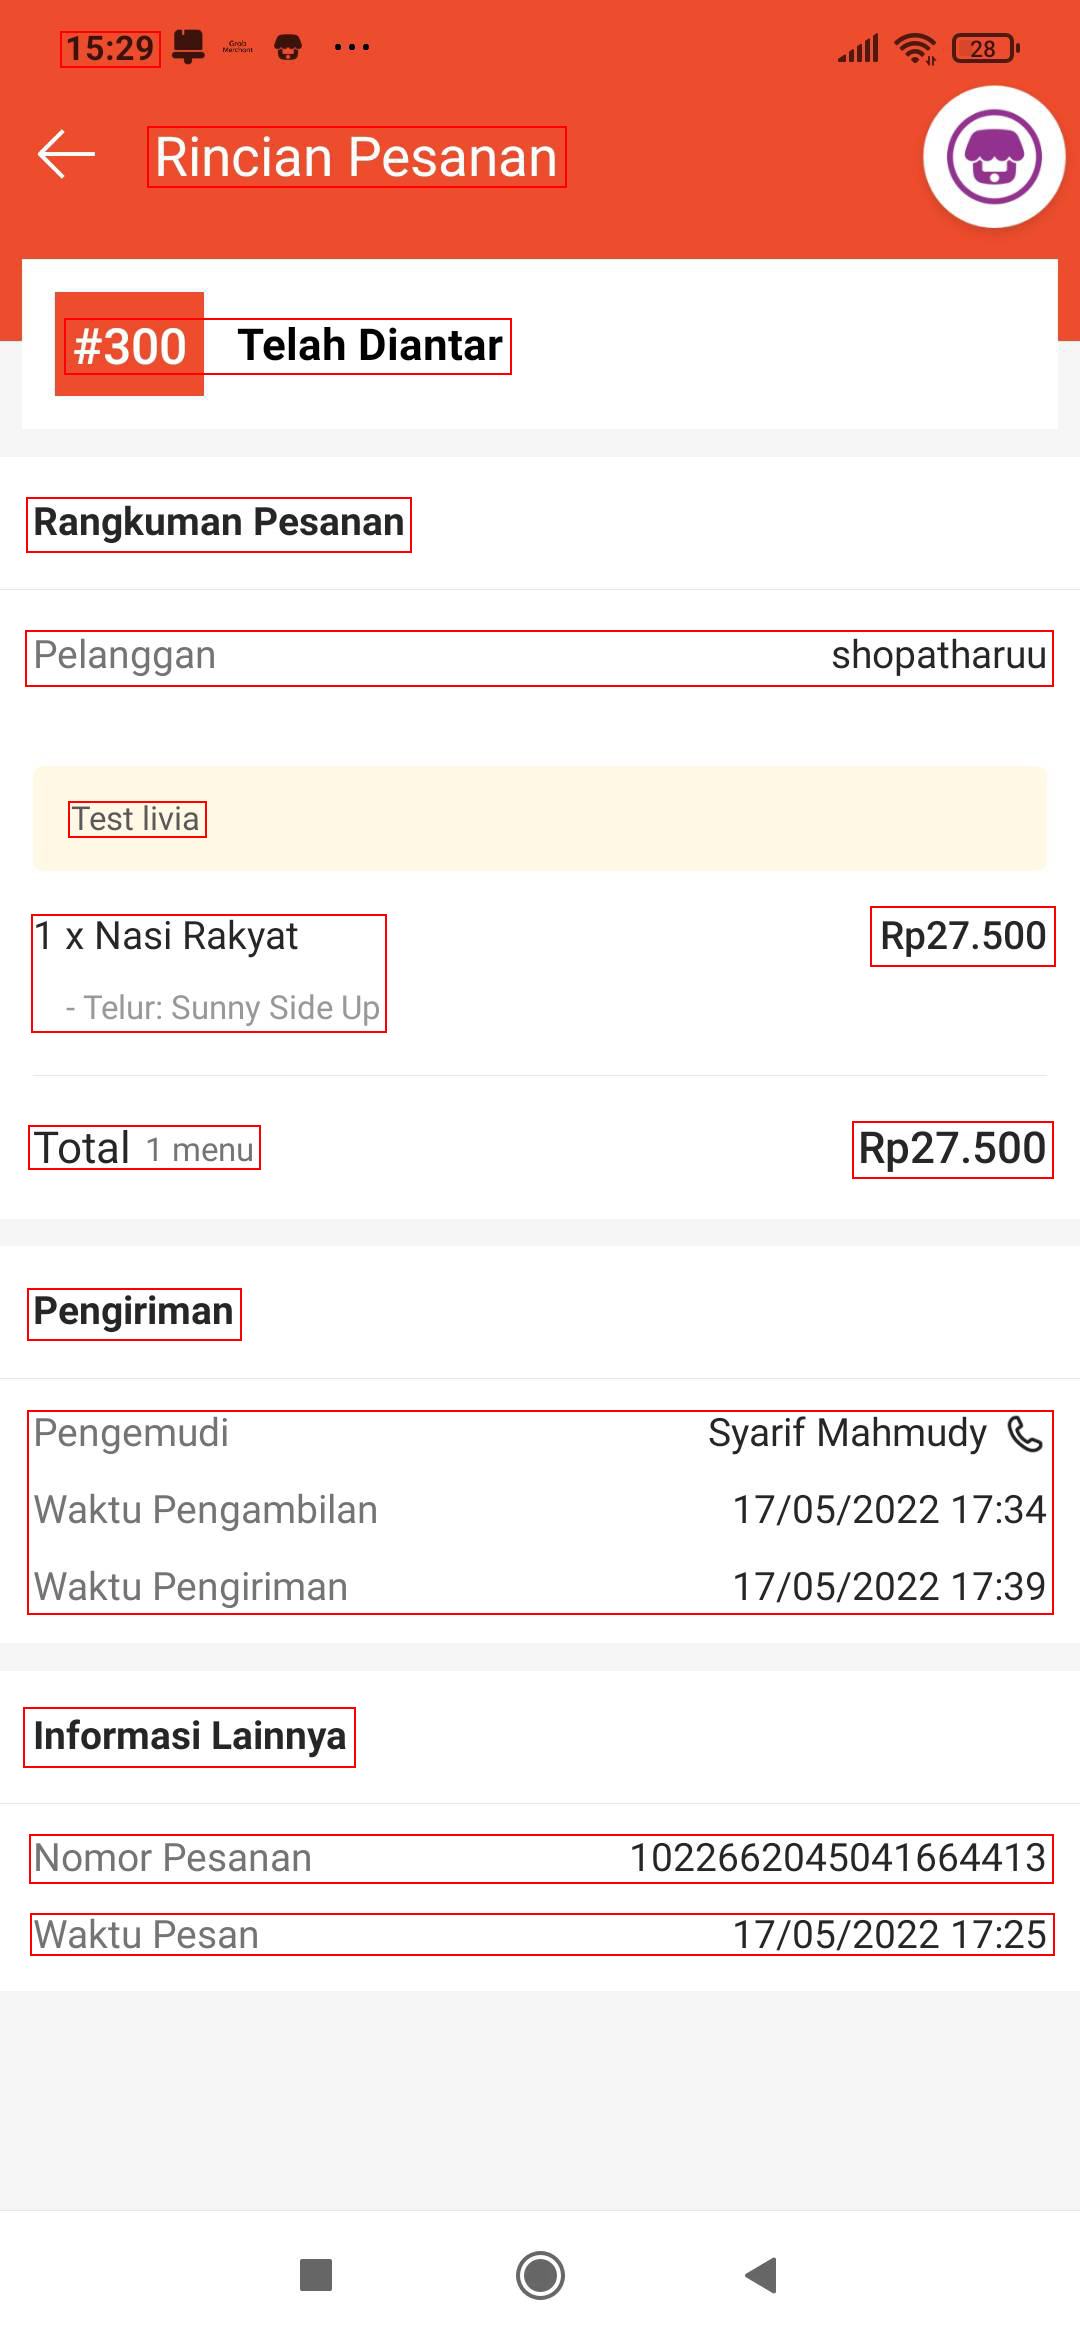

In [ ]:
draw_boxes(shp2, shp_text_2)

In [ ]:
draw_boxes(shp3, shp_text_3)

### Output

In [ ]:
for line in shp_text_2:
  if line.startswith("Pelanggan"):
    shp_cus_name = line
    shp_cus_name = shp_cus_name.replace("Pelanggan", "")
    shp_cus_name = shp_cus_name.strip()

shp_cus_name

'shopatharuu'

In [ ]:
for line in shp_text_2:
  if line.startswith("Pengemudi"):
    shp_driver_name = line
    shp_driver_name = shp_driver_name.replace("Pengemudi", "")
    shp_driver_name = shp_driver_name.strip()

shp_driver_name

'Syarif Mahmudy Waktu Pengambilan  17/05/2022 17.34 Waktu Pengiriman  17/05/2022 17.39'

In [ ]:
shp_extracted = []
shp_extracted.extend((shp_cus_name, shp_driver_name))
shp_extracted

['shopatharuu',
 'Syarif Mahmudy Waktu Pengambilan  17/05/2022 17.34 Waktu Pengiriman  17/05/2022 17.39']

## Grab Food

### Input Images

In [ ]:
grab_1 = "/content/Grab_Food/20220426-101528.jpg"
grab_2 = "/content/Grab_Food/20220519-090127.jpg"
grab_3 = "/content/Grab_Food/20220520_101418.jpg"

In [ ]:
grab1 = PIL.Image.open("/content/Grab_Food/20220426-101528.jpg")
grab2 = PIL.Image.open("/content/Grab_Food/20220519-090127.jpg")
grab3 = PIL.Image.open("/content/Grab_Food/20220520_101418.jpg")

### OCR

In [ ]:
grab_text_1 = reader.readtext(grab_1, paragraph = True, decoder = "beamsearch")
grab_text_1

[[[[316, 175], [771, 175], [771, 269], [316, 269]],
  'Wanfan YKAIO  Pasteur) Travelokal GF-537'],
 [[[311, 312], [703, 312], [703, 456], [311, 456]],
  'makanan untuk mikhael julius christian Pengemudimu sudah sampai Pengemudi'],
 [[[306, 485], [550, 485], [550, 548], [306, 548]],
  'ADAM BAGJA MUHARAM +62 8954 2266 9780'],
 [[[647, 606], [836, 606], [836, 649], [647, 649]], 'A-3A7SXXCWWERE'],
 [[[291, 647], [513, 647], [513, 696], [291, 696]], 'Ringkasan Pesanan'],
 [[[285, 732], [506, 732], [506, 779], [285, 779]],
  'mikhael ljulius christian'],
 [[[276, 822], [509, 822], [509, 875], [276, 875]], 'Catatan dari pelanggan'],
 [[[293, 905], [769, 905], [769, 965], [293, 965]],
  "Tidak usah minta alat makan pisau) ' (garpu / sendok /"],
 [[[284, 1037], [806, 1037], [806, 1235], [284, 1235]],
  'Butter Chicken Rice = fan) or (naiyou i ji 42.000,00 Flash Sale 40% -15.273,00 Butter Sauce Dicamnur'],
 [[[342, 1273], [691, 1273], [691, 1332], [342, 1332]],
  'Ubah atau Batalkan Pesanan'],


In [ ]:
grab_text_2 = reader.readtext(grab_2, paragraph = True, detail = 0, decoder = "beamsearch", min_size = 60, width_ths = 15, y_ths = 1.2)
grab_text_2

['15:28',
 '4ill =1 C28',
 'GF-658',
 '2 makanan untuk Helmy Sipayung Diantarkan 18 Mei, Rab, 13.22',
 'Pengemudi Muhamad Subhan +62 8569 5469 499',
 'Nomor Pemesanan  A-3FPZIDTWWIMO',
 'Ringkasan Pesanan',
 'Catatan dari pelanggan',
 'ketemu di lobby Tidak usah minta alat makan (garpu / sendok / pisau)',
 '2x Butter Soy Sauce Chicken   79.000,00 Soy',
 'Subtotal (kira-kira)   Rp79.ooo,0o Pajak sudah termasuk (Rp7182,00)',
 'Harga Total   Rp79.ooo,00']

In [ ]:
grab_text_3 = reader.readtext(grab_3, paragraph = True, decoder = "beamsearch",  min_size = 60, width_ths = 15, y_ths = 1.2)
grab_text_3

[[[[156, 201], [317, 201], [317, 263], [156, 263]], '12 '],
 [[[847, 376], [1129, 376], [1129, 464], [847, 464]], 'GF-658'],
 [[[110, 674], [1170, 674], [1170, 887], [110, 887]],
  '2 makanan untuk Helmy Sipayung Diantarkan 18 Mei, Rab 13.22'],
 [[[111, 1027], [536, 1027], [536, 1123], [111, 1123]], '[Pengemudi'],
 [[[114, 1248], [672, 1248], [672, 1428], [114, 1428]],
  'Muhamad Subhan 62 85695469490'],
 [[[119, 1577], [1827, 1577], [1827, 2541], [119, 2541]],
  'Nomor Pemesanan   A-3FP2ID7WWIMO Ringkasan Pesanan Catatan dari pelangoan) ketemu di lobby Tidak usah minta alat makan (garpu / sendok / pisau)'],
 [[[119, 2793], [1785, 2793], [1785, 3177], [119, 3177]],
  '2 x Butter Soy Sauce Chicken   79.000,00 Soy Subtotal (kia-kra)orooooloo'],
 [[[127, 3332], [1761, 3332], [1761, 3491], [127, 3491]],
  'Harga Total   Rp79.ooo,0o']]

### Bounding Box

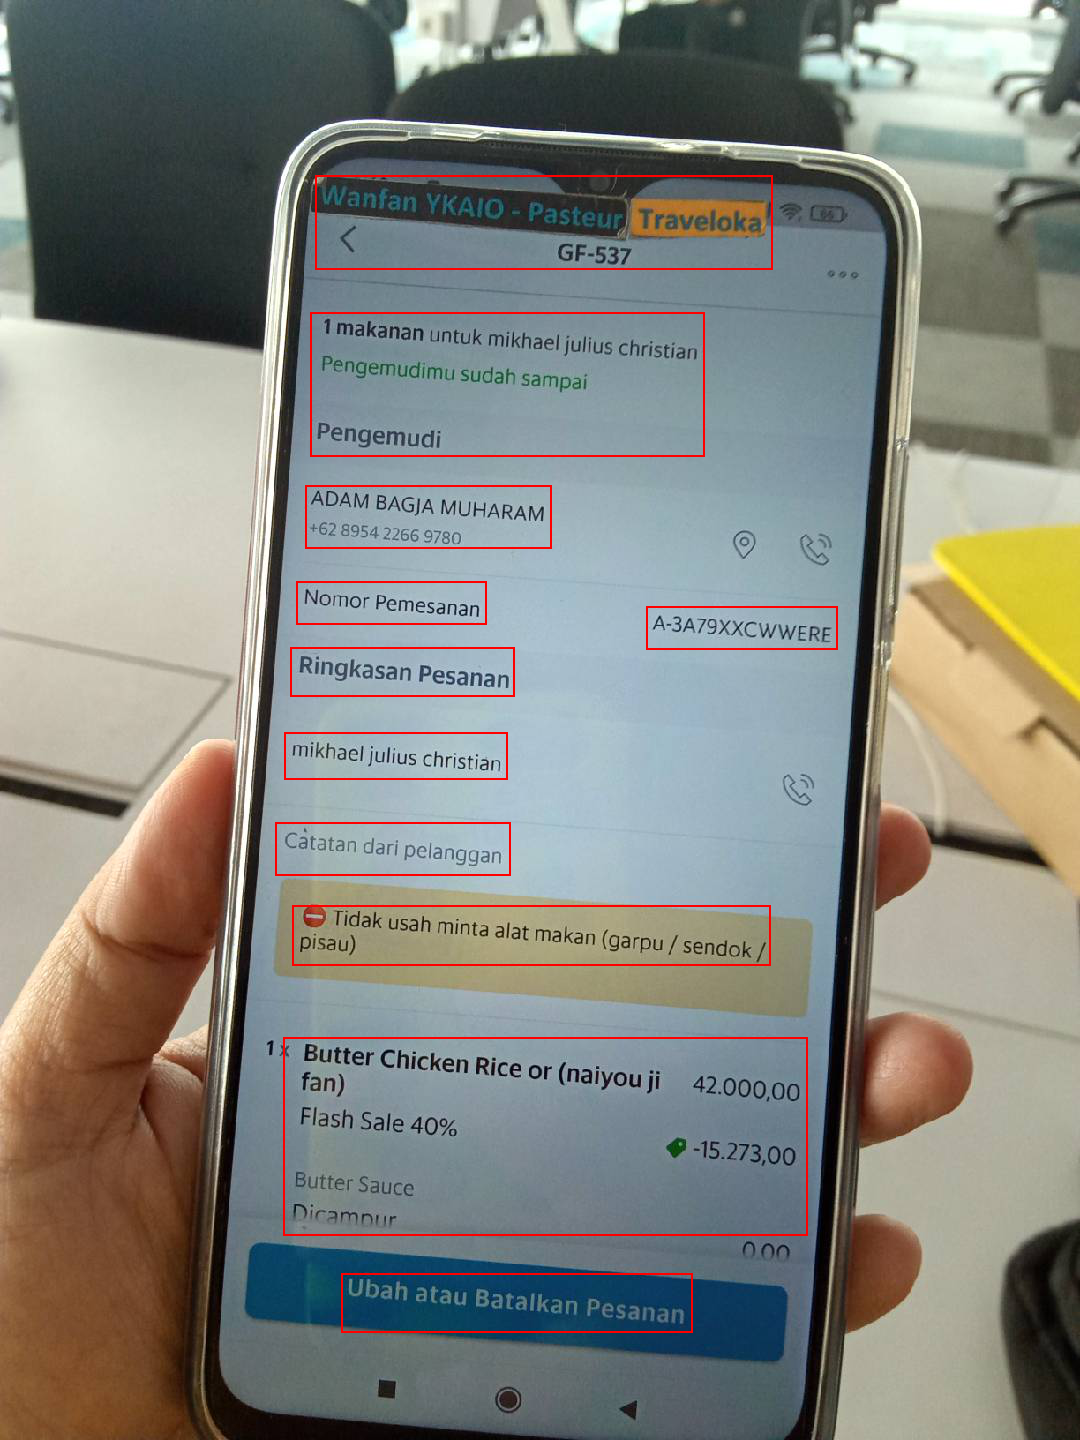

In [ ]:
draw_boxes(grab1, grab_text_1)

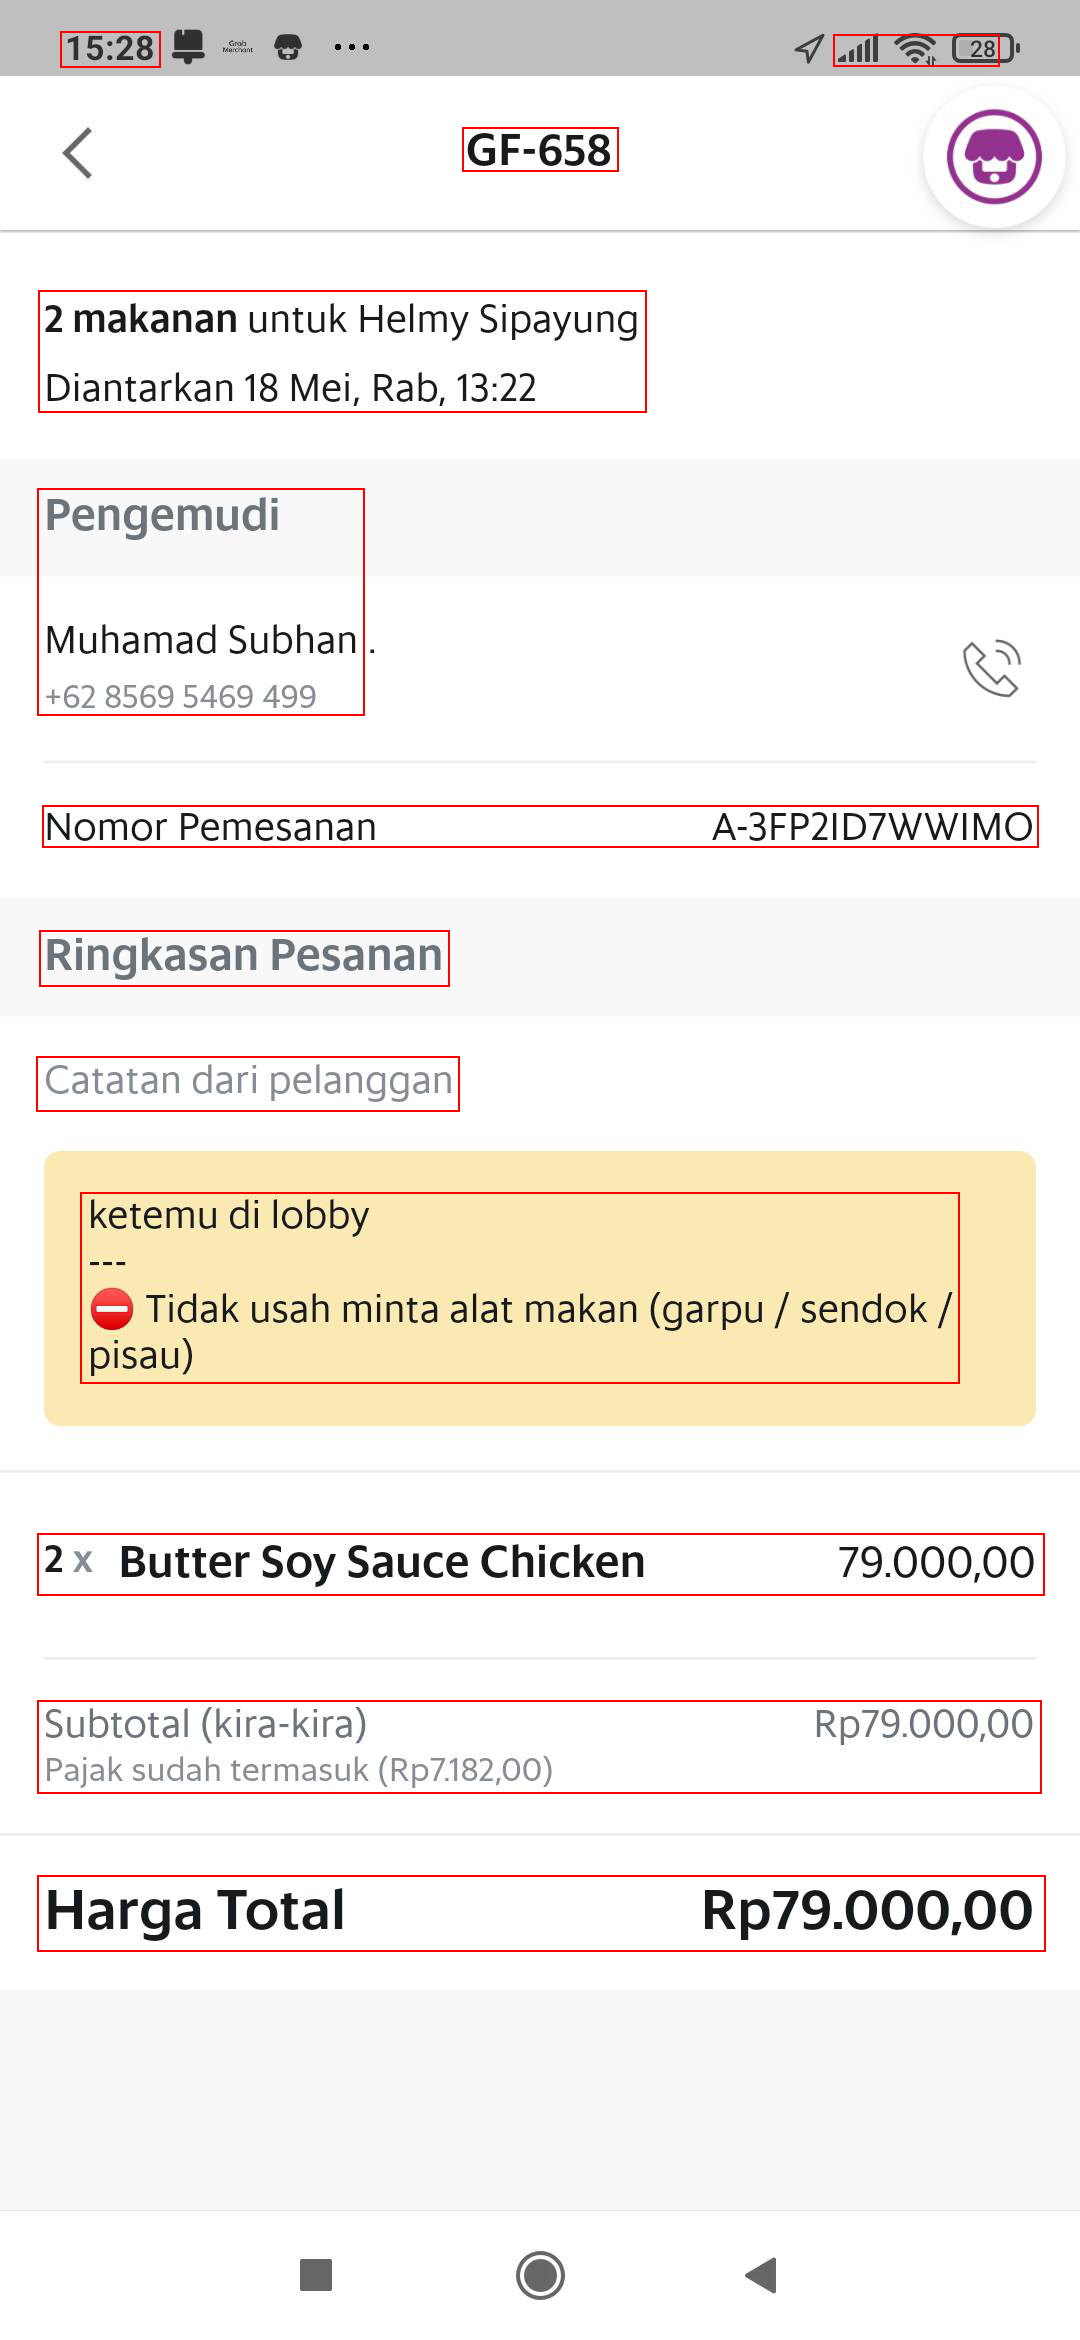

In [ ]:
draw_boxes(grab2, grab_text_2)

In [ ]:
draw_boxes(grab3, grab_text_3)

### Output

In [ ]:
for line in grab_text_2:
  if "Diantarkan" in line:
    grab_cus_name = line
    grab_cus_name = grab_cus_name.replace("Diantarkan", "")
    grab_cus_name = grab_cus_name.strip()

grab_cus_name

'2 makanan untuk Helmy Sipayung  18 Mei, Rab, 13.22'

In [ ]:
for line in grab_text_2:
  if line.startswith("Pengemudi"):
    grab_driver_name = line
    grab_driver_name = grab_driver_name.replace("Pengemudi", "")
    grab_driver_name = grab_driver_name.strip()

grab_driver_name

'Muhamad Subhan +62 8569 5469 499'

In [ ]:
grab_extracted = []
grab_extracted.extend((grab_cus_name, grab_driver_name))
grab_extracted

['2 makanan untuk Helmy Sipayung  18 Mei, Rab, 13.22',
 'Muhamad Subhan +62 8569 5469 499']

## Go Food

### Input Images

In [ ]:
go_1 = "/content/Go_Food/20220519-092200.jpg"
go_2 = "/content/Go_Food/20220519-090111.jpg"
go_3 = "/content/Go_Food/20220426-101544.jpg"

In [ ]:
go1 = PIL.Image.open("/content/Go_Food/20220519-092200.jpg")
go2 = PIL.Image.open("/content/Go_Food/20220519-090111.jpg")
go3 = PIL.Image.open("/content/Go_Food/20220426-101544.jpg")

### OCR

In [ ]:
go_text_1 = reader.readtext(go_1, paragraph = True, detail = 0, decoder = "beamsearch")
go_text_1

['16:47',
 '746roa L',
 '73',
 'Detail pesanan',
 'halomoan F-1697448240',
 '8',
 '17 Mei, 18.26',
 '2 x Beef Blackpepper',
 '57.000',
 'Subtotal',
 'Rp5zooo',
 'Diskon total belanja resto',
 '~Rpn.ooo',
 'Total',
 'Rp46.ooo',
 'Widodo Saputro',
 'Makanan udah diantar',
 'Waktu persiapan tidak tercatat']

#### Test driver name

In [ ]:
idx_text = go_text_1.index('Detail pesanan')
idx_text+=1
idx_new_text = go_text_1[idx_text]

In [ ]:
  # Transaction ID
a_num = re.findall(r'\d+', idx_new_text)
a = ''.join(map(str, a_num))
a = 'F-'+ a
print(a)
  
  # Customer name
b = idx_new_text.replace("F-", "")
b = re.sub(r'[^a-zA-Z ]+', '', b)
b = b.strip()
print(b)

F-1697448240
halomoan


#### Test filtering

In [ ]:
idx_text_2 = go_text_1.index('Total')
idx_text_2 += 2
go_driver_name = go_text_1[idx_text]

In [ ]:
r = re.compile(".*F-")
newlist = list(filter(r.match, go_text_1)) # Read Note below
print(newlist)
print(type(newlist))

['halomoan F-1697448240']
<class 'list'>


In [ ]:
string = ''.join(map(str, newlist))
print(string)
print(type(string))

halomoan F-1697448240
<class 'str'>


In [ ]:
r = re.compile(".*F-")
newlist = list(filter(r.match, go_text_1))
new_text = ''.join(map(str, newlist))

# Customer name
go_cus_name = new_text.replace("F-", "")
go_cus_name = re.sub(r'[^a-zA-Z ]+', '', go_cus_name)
go_cus_name = go_cus_name.strip()
print(go_cus_name)
print(type(go_cus_name))

halomoan
<class 'str'>


In [ ]:
new_text = ''.join(map(str, newlist))

# Transaction ID
go_trans_id_num = re.findall(r'\d+', new_text)
print(go_trans_id_num)
print(type(go_trans_id_num))
go_trans_id = ''.join(map(str, go_trans_id_num))
go_trans_id = 'F-'+ go_trans_id
print(go_trans_id)

['1697448240']
<class 'list'>
F-1697448240


### A

In [ ]:
go_text_2 = reader.readtext(go_2, paragraph = True, decoder = "beamsearch", min_size = 60)
go_text_2

[[[[61, 30], [158, 30], [158, 66], [61, 66]], '15.28'],
 [[[195, 123], [540, 123], [540, 192], [195, 192]], 'Detail pesanan'],
 [[[180, 296], [719, 296], [719, 405], [180, 405]],
  'Meidy Ruth F-1698112243 18 Mei, 11:49'],
 [[[979, 321], [1041, 321], [1041, 385], [979, 385]], '8'],
 [[[76, 513], [623, 513], [623, 572], [76, 572]],
  '2 x Butter SoY Sauce Chicken'],
 [[[873, 520], [1005, 520], [1005, 560], [873, 560]], '47.400'],
 [[[126, 626], [603, 626], [603, 679], [126, 679]],
  'jangan pedas ya kak. makasi'],
 [[[77, 764], [475, 764], [475, 826], [77, 826]], '1 x Beef Blackpepper'],
 [[[861, 771], [1005, 771], [1005, 813], [861, 813]], '28.500'],
 [[[126, 876], [572, 876], [572, 929], [126, 929]],
  'jangan terlalu pedas ya kak'],
 [[[39, 1015], [199, 1015], [199, 1059], [39, 1059]], 'Subtotal'],
 [[[852, 1016], [1042, 1016], [1042, 1068], [852, 1068]], 'Rp75.900'],
 [[[40, 1102], [510, 1102], [510, 1152], [40, 1152]],
  'Diskon total belanja resto'],
 [[[854, 1104], [1042, 1104], 

In [ ]:
go_text_3 = reader.readtext(go_3, decoder = "beamsearch", paragraph = True, min_size = 50, width_ths = 15)
go_text_3

[[[[199, 183], [253, 183], [253, 199], [199, 199]], '10-45'],
 [[[167, 191], [608, 191], [608, 271], [167, 271]],
  'Kyochon / Dailybox - Kebagusan Detail pesanan'],
 [[[271, 334], [590, 334], [590, 395], [271, 395]],
  'VINA ASYWILLA F-1648723501 | 05 Apr; 10:39'],
 [[[225, 449], [743, 449], [743, 485], [225, 485]], 'x Paket Yummy 3 73.950'],
 [[[189, 530], [764, 530], [764, 614], [189, 614]],
  'Subtotal  Rp73.950 Diskon total belanja resto-Rp11.550'],
 [[[192, 660], [248, 660], [248, 684], [192, 684]], 'Total'],
 [[[650, 654], [764, 654], [764, 684], [650, 684]], 'Rp62.400'],
 [[[276, 757], [490, 757], [490, 820], [276, 820]],
  'Wahyu Sukilo Sampai dalam 3 menit.'],
 [[[210, 872], [492, 872], [492, 962], [210, 962]],
  'Driver belum mengisi PIN 1884'],
 [[[202, 1164], [718, 1164], [718, 1194], [202, 1194]],
  'Sisa waktu persiapan   09;12'],
 [[[330, 1256], [634, 1256], [634, 1301], [330, 1301]],
  'Tandain pesanan udah siap'],
 [[[430, 1364], [528, 1364], [528, 1390], [430, 1390]]

### Bounding Box

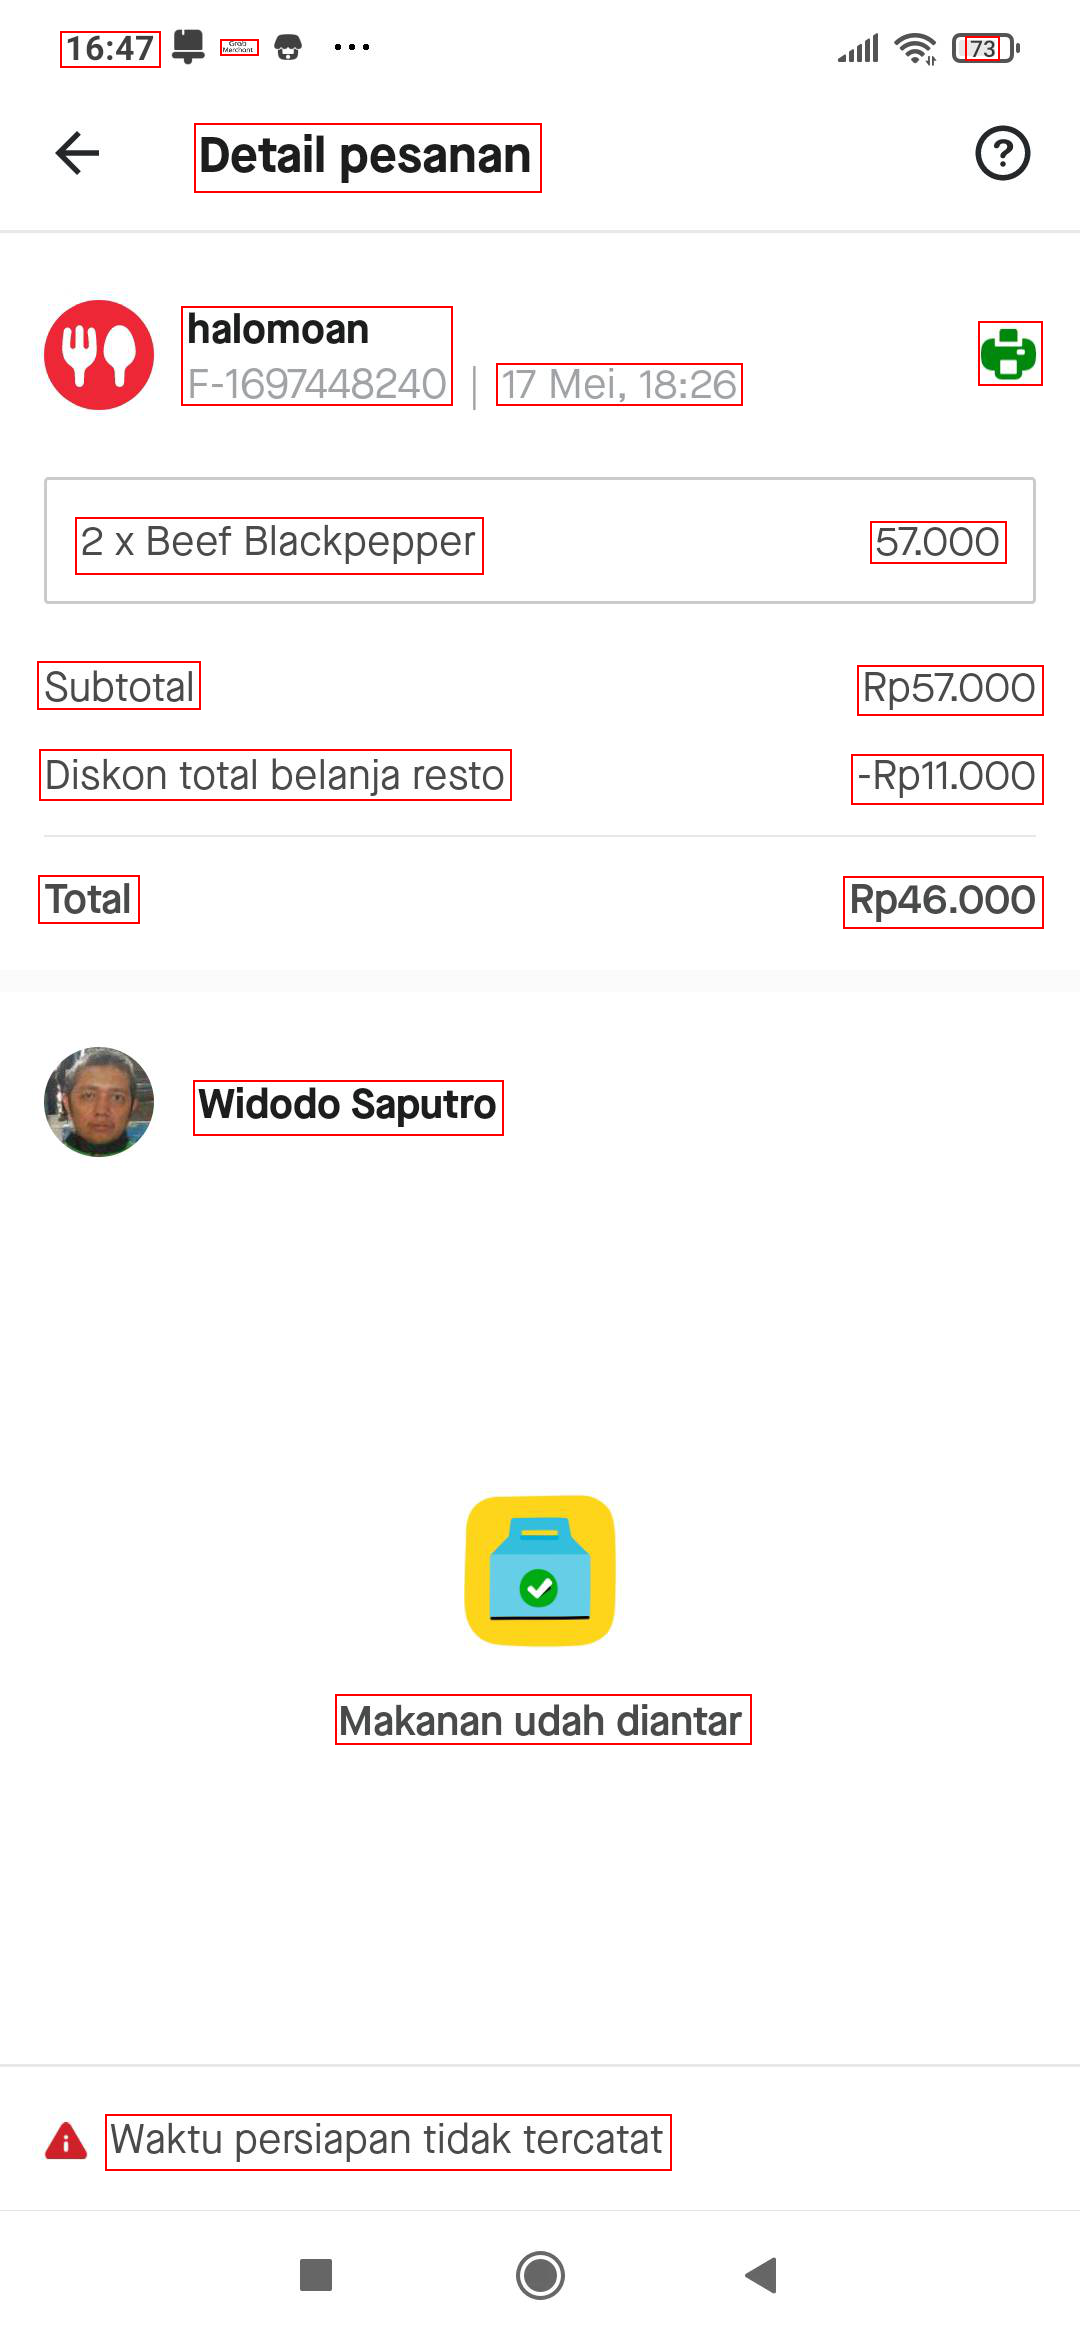

In [ ]:
draw_boxes(go1, go_text_1)

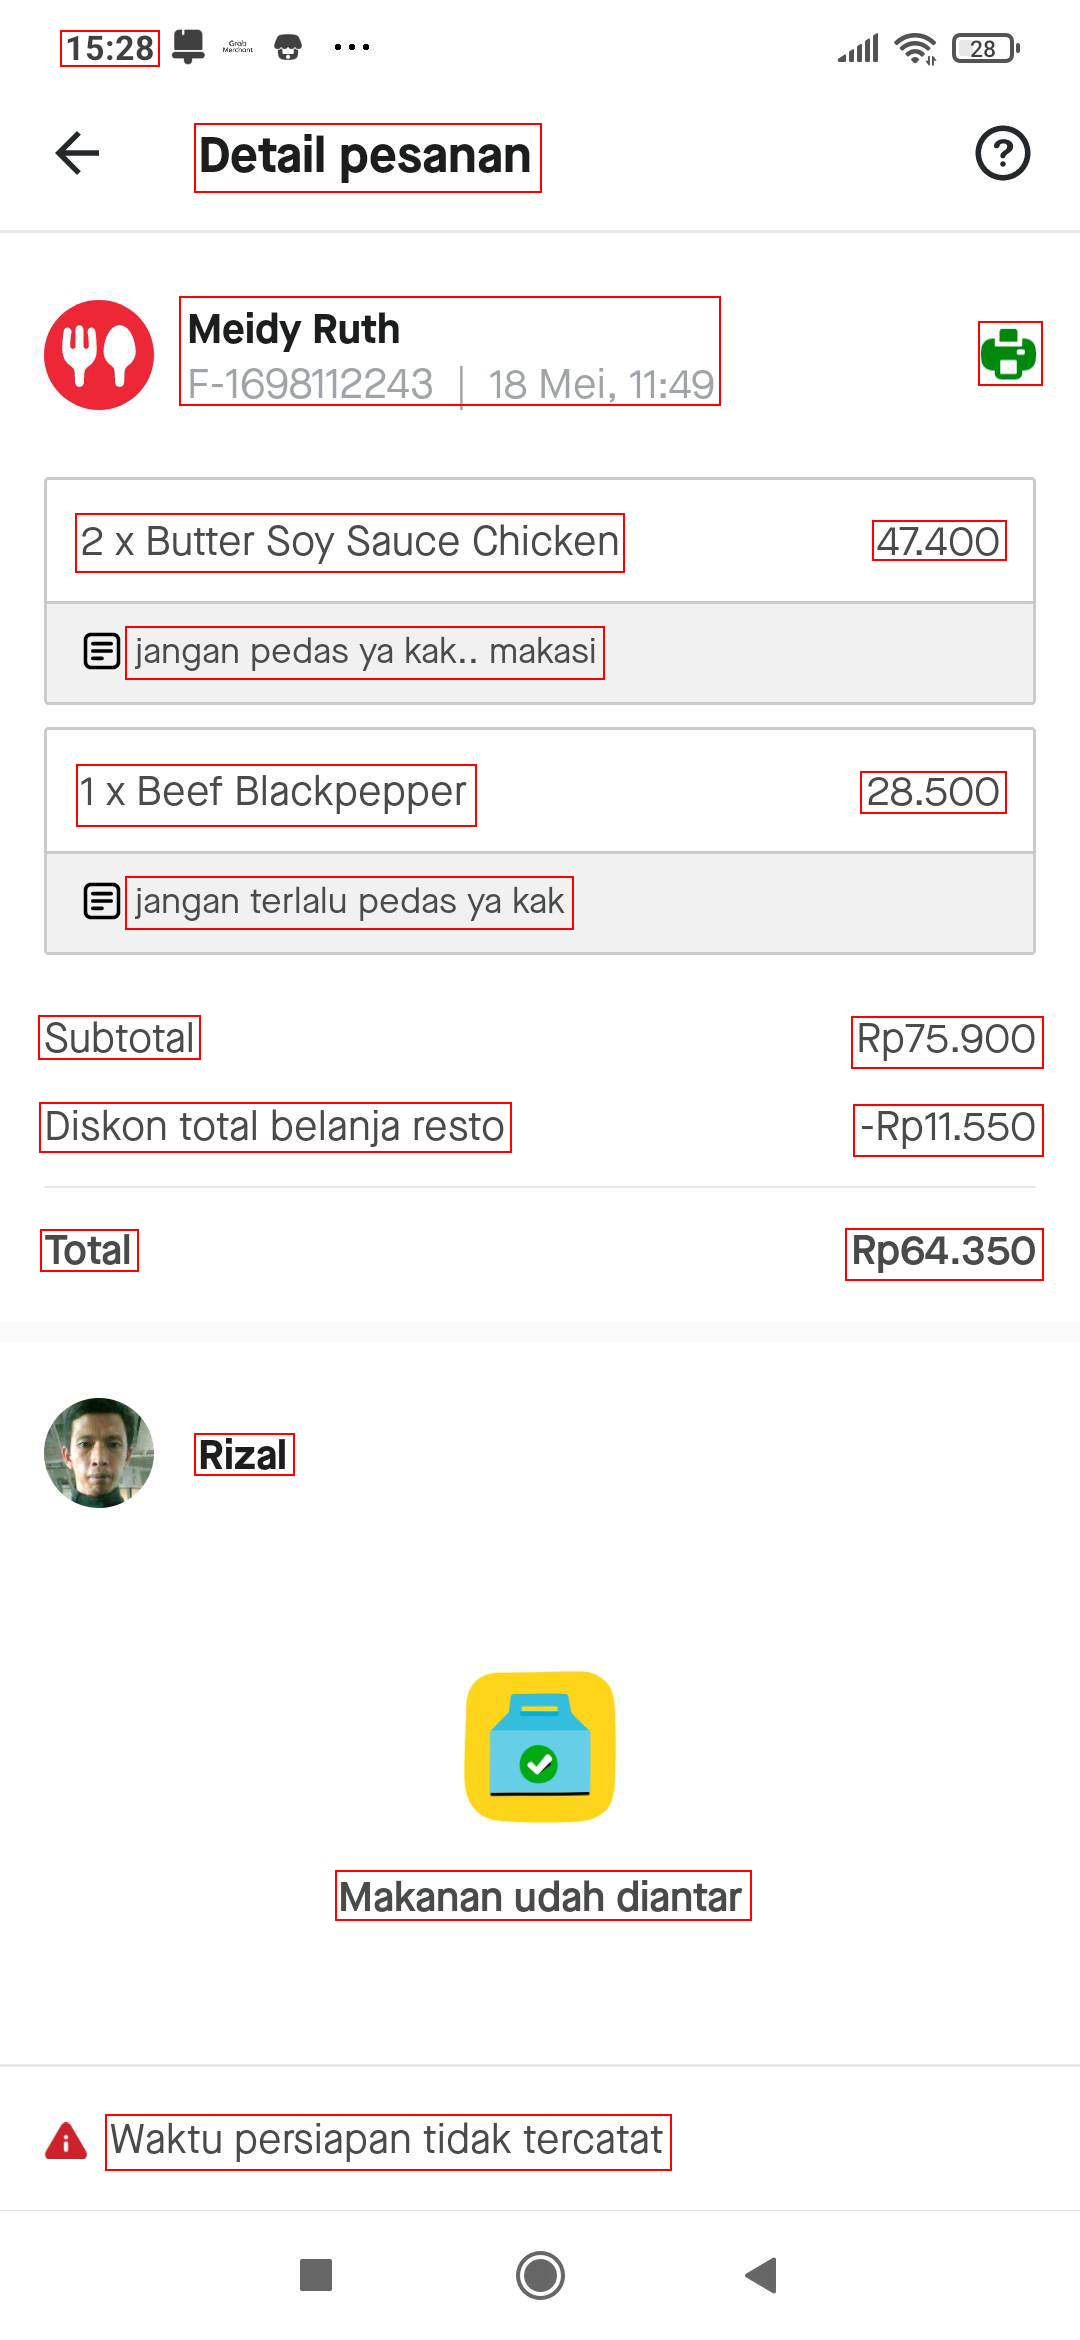

In [ ]:
draw_boxes(go2, go_text_2)

In [ ]:
draw_boxes(go3, go_text_3)

## Filtering

### Create CSV Function

In [ ]:
# Generate CSV from data
def create_csv(date, transaction_id, customer_name, driver_name, brand):
  df = pd.DataFrame({'date': date, 'transaction_id': transaction_id, 'customer_name': customer_name, 'driver_name': driver_name, 'brand': brand}, index=[0])
  df.to_csv("invoice_ocr.csv", index = False)

### Bigquery (and Firebase) Function

In [ ]:
# Send data to biqguery
def input_data(df):
    # Import csv to BigQuery
    with open('invoice_ocr.csv', "rb") as source_file:
        job = client.load_table_from_file(source_file, table_ref, job_config = job_config)
    job.result()

    # # Export dataframe/csv to firebase
    # tmp = df.to_dict(orient='records')
    # list(map(lambda x: doc_ref.add(x), tmp))

### Filtering Function

In [ ]:
# OCR for traveloka
def traveloka(image):
  trav_brand = "Traveloka"
  trav_text = reader.readtext(input_image, paragraph = True, detail = 0, decoder = "beamsearch", width_ths = 15)

  trav_trans_id = '-'
  trav_cus_name = '-'
  trav_driver_name = '-'

  # Transaction ID
  for line in trav_text:
    if line.isdigit() or "ID" in line:
      trav_trans_id = line
      trav_trans_id = trav_trans_id.replace("ID", "")
      trav_trans_id = trav_trans_id.strip()
  
  # Customer name
  for line in trav_text:
    if "Nama Pelanggan" in line:
      trav_cus_name = line
      trav_cus_name = trav_cus_name.replace("Nama Pelanggan", "")
      trav_cus_name = trav_cus_name.strip()

  # Driver name
  for line in trav_text:
    if "Nama Kurir" in line:
      trav_driver_name = line
      trav_driver_name = trav_driver_name.replace("Nama Kurir", "")
      trav_driver_name = trav_driver_name.strip()

  # Dataframe for bigquery
  df = pd.DataFrame({'date': current_time, 'transaction_id': str(trav_trans_id), 'customer_name': trav_cus_name, 'driver_name': trav_driver_name, 'brand': trav_brand}, index=[0])
  df.to_csv("invoice_ocr.csv", index = False)

  # # Create variable data for json
  # data = {'date': current_time, 'transaction_id': trav_trans_id, 'customer_name': trav_cus_name, 'driver_name': trav_driver_name, 'brand': trav_brand}

  # Function to input data
  # input_data(df)
  df.to_gbq(tbl_id, project_id = PROJECT_ID, if_exists = 'append', progress_bar = False)

  # print(df.dtypes)
  print(df.head())

# OCR for shopee
def shopee(image):
  shp_brand = "Shopee"
  shp_text = reader.readtext(input_image, paragraph = True, detail = 0, decoder = "beamsearch", width_ths = 15)

  shp_trans_id = '-'
  shp_cus_name = '-'
  shp_driver_name = '-'

  # Transaction ID
  for line in shp_text:
    if "Nomor Pesanan" in line:
      shp_trans_id = line
      shp_trans_id = shp_trans_id.replace("Nomor Pesanan", "")
      shp_trans_id = shp_trans_id.strip()
  
  # Customer name
  for line in shp_text:
    if "Pelanggan" in line:
      shp_cus_name = line
      shp_cus_name = shp_cus_name.replace("Pelanggan", "")
      shp_cus_name = shp_cus_name.strip()

  # Driver name    
  for line in shp_text:
    if "Pengemudi" in line:
      shp_driver_name = line
      shp_driver_name = shp_driver_name.replace("Pengemudi", "").replace("Waktu", "").replace("Pengambilan", "").replace("Pengiriman", "").replace("Perkiraan", "").replace("Diambil", "")
      shp_driver_name = re.sub(r'[^a-zA-Z ]+', '', shp_driver_name)
      shp_driver_name = shp_driver_name.strip()
    
  # Dataframe for bigquery
  df = pd.DataFrame({'date': current_time, 'transaction_id': str(shp_trans_id), 'customer_name': shp_cus_name, 'driver_name': shp_driver_name, 'brand': shp_brand}, index=[0])
  df.to_csv("invoice_ocr.csv", index = False)

  # # Create variable data for json
  # data = {'date': current_time, 'transaction_id': shp_trans_id, 'customer_name': shp_cus_name, 'driver_name': shp_driver_name, 'brand': shp_brand}

  # Function to input data
  # input_data(df)
  df.to_gbq(tbl_id, project_id = PROJECT_ID, if_exists = 'append', progress_bar = False)

  # print(df.dtypes)
  print(df.head())


# OCR for grab
def grab(image):
  grab_brand = "Grab Food"
  grab_text = reader.readtext(input_image, paragraph = True, detail = 0, decoder = "beamsearch", width_ths = 15, y_ths = 1.35)

  grab_trans_id = '-'
  grab_cus_name = '-'
  grab_driver_name = '-'

  # Transaction ID
  for line in grab_text:
    if "Nomor Pemesanan" in line:
      grab_trans_id = line
      grab_trans_id = grab_trans_id.replace("Nomor Pemesanan", "")
      grab_trans_id = grab_trans_id.strip()

  # Customer name
  for line in grab_text:
    if "makanan untuk" in line:
      grab_cus_name = line
      grab_cus_name = grab_cus_name.replace("makanan", "").replace("untuk", "").replace("Diantarkan", "")
      grab_cus_name = grab_cus_name.replace("Pengemudimu", "").replace("sudah", "").replace("sampai", "")
      grab_cus_name = grab_cus_name.replace("Sen", "").replace("Sel", "").replace("Rab", "").replace("Kam", "").replace("Jum", "").replace("Sab", "").replace("Min", "")
      grab_cus_name = grab_cus_name.replace("Jan", "").replace("Feb", "").replace("Mar", "").replace("Apr", "").replace("Mei", "").replace("Jun", "")
      grab_cus_name = grab_cus_name.replace("Jul", "").replace("Agu", "").replace("Sep", "").replace("Okt", "").replace("Nov", "").replace("Des", "")
      grab_cus_name = re.sub(r'[^a-zA-Z ]+', '', grab_cus_name)
      grab_cus_name = grab_cus_name.strip()

  # Driver name
  for line in grab_text:
    if "Pengemudi" in line:
      grab_driver_name = line
      grab_driver_name = grab_driver_name.replace("Pengemudi", "")
      grab_driver_name = re.sub(r'[^a-zA-Z ]+', '', grab_driver_name)
      grab_driver_name = grab_driver_name.strip()
  
  # Dataframe for bigquery
  df = pd.DataFrame({'date': current_time, 'transaction_id': str(grab_trans_id), 'customer_name': grab_cus_name, 'driver_name': grab_driver_name, 'brand': grab_brand}, index=[0])
  df.to_csv("invoice_ocr.csv", index = False)

  # # Create variable data for json
  # data = {'date': current_time, 'transaction_id': grab_trans_id, 'customer_name': grab_cus_name, 'driver_name': grab_driver_name, 'brand': grab_brand}

  # Function to input data
  # input_data(df)
  df.to_gbq(tbl_id, project_id = PROJECT_ID, if_exists = 'append', progress_bar = False)

  # print(df.dtypes)
  print(df.head())
  
# OCR for gofood
def gofood(image):

  go_brand = "Go Food"
  go_text = reader.readtext(input_image, paragraph = True, detail = 0, decoder = "beamsearch")

  go_trans_id = '-'
  go_cus_name = '-'
  go_driver_name = '-'

  # Using index to obtain line for customer name and transaction id
  idx_text = go_text_1.index('Detail pesanan')
  idx_text+=1
  new_text = go_text[idx_text]

  # # Regex to obtain line
  # r = re.compile(".*F-")
  # newlist = list(filter(r.match, go_text))
  # new_text = ''.join(map(str, newlist))

  # Transaction ID
  go_trans_id_num = re.findall(r'\d+', new_text)
  go_trans_id = ''.join(map(str, go_trans_id_num))
  go_trans_id = 'F-'+ go_trans_id
  
  # Customer name
  go_cus_name = new_text.replace("F-", "")
  go_cus_name = re.sub(r'[^a-zA-Z ]+', '', go_cus_name)
  go_cus_name = go_cus_name.strip()

  # Driver name
  idx_text_2 = go_text.index('Total')
  idx_text_2 += 2
  go_driver_name = go_text[idx_text_2]

  # Dataframe for bigquery
  df = pd.DataFrame({'date': current_time, 'transaction_id': str(go_trans_id), 'customer_name': go_cus_name, 'driver_name': go_driver_name, 'brand': go_brand}, index=[0])
  df.to_csv("invoice_ocr.csv", index = False)

  # Function to input data
  df.to_gbq(tbl_id, project_id = PROJECT_ID, if_exists = 'append', progress_bar = False)

  # print(df.dtypes)
  print(df.head())

In [ ]:
input_image = "/content/Go_Food/20220519-092200.jpg"

In [ ]:
print(type(input_image))

<class 'str'>


In [ ]:
auth.authenticate_user()

In [ ]:
# Process auth to BigQuery
PROJECT_ID = 'ocr-invoice-351506'
client = bigquery.Client(project = PROJECT_ID)
dataset_id = 'text_ocr'
table_id = 'invoice_data'
tbl_id = 'text_ocr.invoice_data'

# Set parameter for import csv to BigQuery
# dataset_ref = client.dataset(dataset_id)
# table_ref = dataset_ref.table(table_id)
# job_config = bigquery.LoadJobConfig()
# job_config.source_format = bigquery.SourceFormat.CSV
# job_config.autodetect = True

# Initial OCR
text = reader.readtext(input_image, paragraph = True, decoder = 'beamsearch',detail = 0)

# Webcam

# Define variable for current time
current_time = datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")

# Filtering
for line in text:
  if "Data Transaksi" in line:
    traveloka(input_image)

  elif "Rincian Pesanan" in line:
    shopee(input_image)

  elif "GF-" in line:
    grab(input_image)

  elif "Detail pesanan" in line:
    gofood(input_image)

                  date transaction_id customer_name     driver_name    brand
0  20-06-2022 07:28:51   F-1697448240      halomoan  Widodo Saputro  Go Food


## Driver Invoice

### Shopee

In [ ]:
shp_driv = cv2.imread("/content/Shopee(1).jpg")
shp_drive_bw = cv2.cvtColor(shp_driv, cv2.COLOR_BGR2GRAY)

In [ ]:
shp_driv_1 = PIL.Image.open("/content/Shopee(1).jpg")
shp_drive_1_bw = PIL.Image.open("/content/Shopee(1).jpg").convert('L')

#### Denoising

In [ ]:
noiseless_image_bw = cv2.fastNlMeansDenoising(shp_drive_bw, None, 20, 7, 21) 

#### OCR

In [ ]:
shp_driver_text = reader.readtext(shp_driv, paragraph = True, decoder = "beamsearch")
shp_driver_text

[[[[5, 17], [43, 17], [43, 35], [5, 35]], 'm906'],
 [[[40, 48], [180, 48], [180, 56], [40, 56]], 'Qullll] 00aiuen uru'],
 [[[208, 48], [290, 48], [290, 54], [208, 54]], 'ekarnn'],
 [[[37, 77], [287, 77], [287, 129], [37, 129]],
  'bco merdclo mos. icon Wolk mall cimnones JL royo merdcha cimone Jayohorouaci Karawaci Koia iawgeRang BANTEX'],
 [[[39, 137], [131, 137], [131, 151], [39, 151]], 'Poncrlma nca oulio'],
 [[[36, 192], [133, 192], [133, 210], [36, 210]], 'Pemboyoron Iunoi'],
 [[[11, 221], [103, 221], [103, 237], [11, 237]], 'Dovor tunal Rusto'],
 [[[305, 221], [327, 221], [327, 235], [305, 235]], 'Rpo'],
 [[[11, 247], [155, 247], [155, 263], [11, 263]],
  'TerImo Pemboyuron dari Penbel'],
 [[[305, 247], [327, 247], [327, 261], [305, 261]], 'Rpo'],
 [[[39, 302], [119, 302], [119, 319], [39, 319]], 'Rincion Borong'],
 [[[11, 335], [181, 335], [181, 369], [11, 369]],
  'Iu Palt Nasł Bali nvorn Suue Mounuhslrmong'],
 [[[279, 331], [327, 331], [327, 345], [279, 345]], 'Rpu3ooo'],
 [[[

In [ ]:
shp_driver_text_bw = reader.readtext(noiseless_image_bw, paragraph = True, decoder = "beamsearch")
shp_driver_text_bw

[[[[7, 19], [43, 19], [43, 35], [7, 35]], '"9o6'],
 [[[120, 48], [180, 48], [180, 54], [120, 54]], '(foeaan 0en'],
 [[[210, 48], [260, 48], [260, 54], [210, 54]], '74nnan0eddd'],
 [[[37, 77], [287, 77], [287, 129], [37, 129]],
  'bco (nrolohin (oe  /710141 Qnnollde (nuil/ auonnne uuo Mrethelu 0tluoe Juuu  Vo(uun Kiuuauuo? Kiin Imuewumts Wimiim'],
 [[[36, 192], [133, 192], [133, 210], [36, 210]], 'Pembuyoron Imnni'],
 [[[11, 223], [103, 223], [103, 237], [11, 237]], 'Ioyue (uo Auato'],
 [[[305, 221], [327, 221], [327, 235], [305, 235]], 'Rpo'],
 [[[14, 249], [155, 249], [155, 263], [14, 263]],
  'Tcknen Prmhovun don Purnbedl'],
 [[[305, 247], [327, 247], [327, 261], [305, 261]], 'Rpo'],
 [[[39, 302], [119, 302], [119, 319], [39, 319]], 'Rincian Burng'],
 [[[11, 335], [95, 335], [95, 349], [11, 349]], 'Iu Patz Wasl Ball'],
 [[[279, 331], [327, 331], [327, 345], [279, 345]], 'Rpuzooo'],
 [[[13, 385], [77, 385], [77, 399], [13, 399]], 'Iotul Menu'],
 [[[41, 441], [137, 441], [137, 457], [4

#### Bounding Box

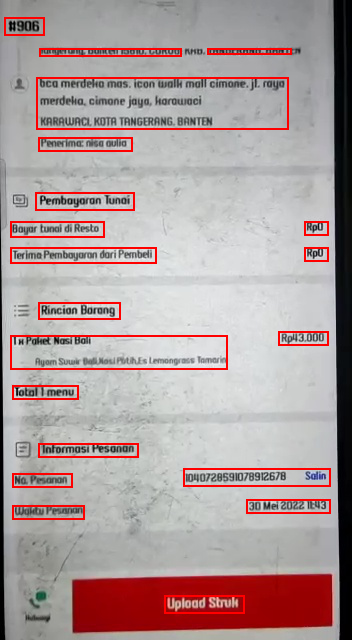

In [ ]:
draw_boxes(shp_driv_1, shp_driver_text)

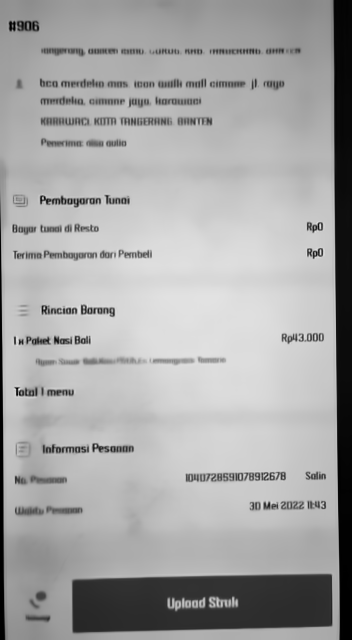

In [ ]:
cv2_imshow(noiseless_image_bw)

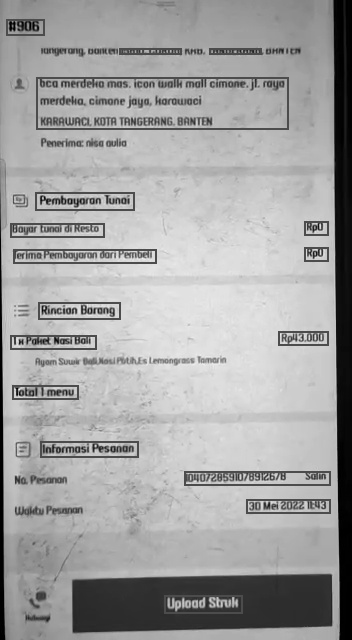

In [ ]:
draw_boxes(shp_drive_1_bw, shp_driver_text_bw)

#### Preprocessed

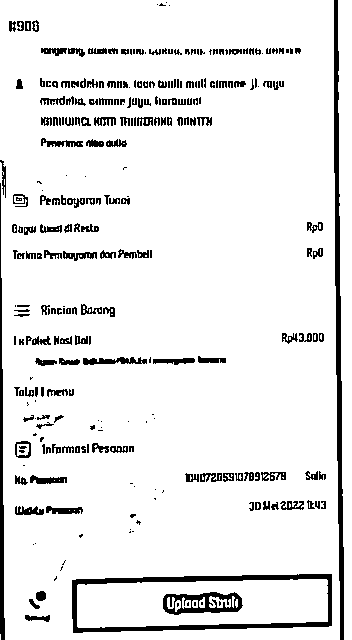

In [ ]:
image = cv2.imread("/content/Shopee(1).jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# converting it to binary image
#threshold_img = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Adaptive thresholding
threshold_img = cv2.adaptiveThreshold(noiseless_image_bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
cv2_imshow(threshold_img)

### Grab

In [ ]:
grab_driv1 = cv2.imread("/content/Grab(12).jpg")
grab_drive1_bw = cv2.cvtColor(grab_driv1, cv2.COLOR_BGR2GRAY)

grab_driv2 = "/content/Grab(8).jpg"

In [ ]:
grab_driv_1 = PIL.Image.open("/content/Grab(12).jpg")
grab_driv_2 = PIL.Image.open("/content/Grab(8).jpg")

#### OCR

In [ ]:
grab_driver_text1 = reader.readtext(grab_drive1_bw, paragraph = True, decoder = "beamsearch", min_size = 50)
grab_driver_text1

[[[[168, 198], [232, 198], [232, 206], [168, 206]], 'Amborderan'],
 [[[78, 238], [305, 238], [305, 289], [78, 289]],
  'Wakasimurah Yummykitchen Karawaci Wakasimurah Yummykitchen Karawaci; Jı Palem Raja Raya RV Bencongan Indah _'],
 [[[139, 529], [199, 529], [199, 545], [139, 545]], 'Mulal lagl']]

In [ ]:
grab_driver_text2 = reader.readtext(grab_driv2, paragraph = True, decoder = "beamsearch", min_size = 27.5)
grab_driver_text2

[[[[101, 33], [129, 33], [129, 45], [101, 45]], '71,21'],
 [[[301, 45], [345, 45], [345, 59], [301, 59]], '2 0815'],
 [[[201, 71], [243, 71], [243, 85], [201, 85]], 'Orderan'],
 [[[104, 103], [329, 103], [329, 309], [104, 309]],
  'Ambil dari Wakasimurah - Yummykitchen Karawaci Pelanggan Desi Puspila No. Orderan GF-334 Orderan pelanggan Ayam Geprek Mentai 27.900 Gurin (3,000)'],
 [[[102, 320], [203, 320], [203, 367], [102, 367]],
  'Regular Cutlery Cutlery {10C0)'],
 [[[97, 393], [127, 393], [127, 407], [97, 407]], 'Total'],
 [[[262, 402], [317, 402], [317, 421], [262, 421]], 'Rp27.900'],
 [[[90, 426], [273, 426], [273, 511], [90, 511]],
  'Cataion pelonogan Blok i No 30 Tltlp security nya aja ya Thak usah minta alat makan sendok pisau) (garpu']]

#### Bounding Box

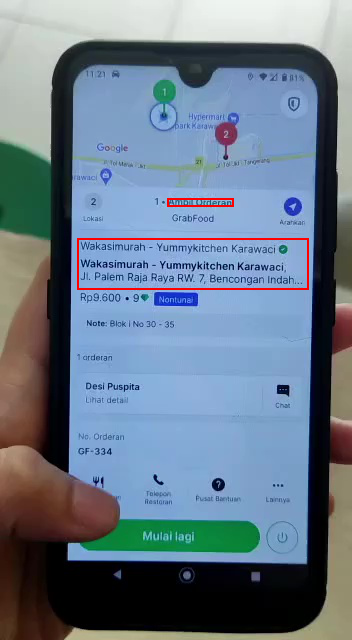

In [ ]:
draw_boxes(grab_driv_1, grab_driver_text1)

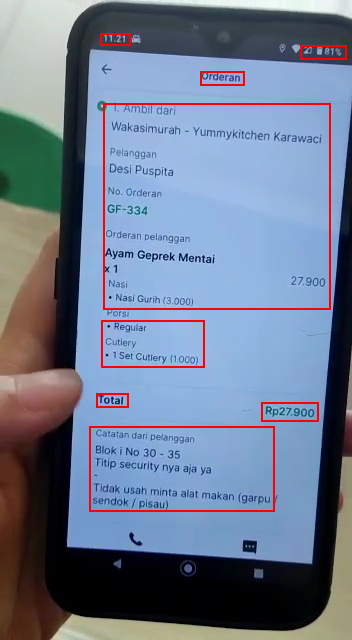

In [ ]:
draw_boxes(grab_driv_2, grab_driver_text2)